# Penalized competing risks and feature selection

#### Philippe Pinel
17th-23rd May 2019

## Description
In this notebook we want to compare the features selected for a model for overall survival, AML transformation and penalized competing risks. For the 2 first it is easy with bootstrapping and LASSO thanks to `glmnet` R package. For competing risks, we use the bootstrapping technique and `crrp` R package. The issue with this package is to find the right lambda, two metrics are given: the BIC and the GCV.

The concordance index for competing risks is defined after the study of `crrp` package, some examples are given thanks to `pec` R package.

### Update 
At the end of this notebook competing risks are described by random forests, using `randomForestSRC` package.



In [3]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library('crrp')
library('pec')
library('randomForestSRC')
library('glmnet')
library('tibble')
library('grid')
library('gridExtra')


source("../../src/merge_df.R")
source("../../src/my_survival.R")
source("../../src/tools.R")
theme_set(theme_bw())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: parallel
Loading required package: RColorBrewer


# BIC

For each model and for each nature of prediction, we count the number of time each feature is selected by the bootstrapping (100 performed) and we rank the features to obtain a feature importance.
For competing risks, two methods are used:
- one run is performed to get the best lambda (minimizing the BIC) on the whole dataset and then the boostrapping is performed with this lambda
- the best lambda (minimizing the BIC) for each bootstrap experiment is chosen (computationally more intense)

The latter will be noted `CR_long`.
The model used is CLIN + DEMO + CYTO + GENE.

In [76]:
ranking<- function(feature_count,with_NA=FALSE){
    
    
    tmp<-1
    i<-1
    for(k in 2:nrow(feature_count)){
        val<-tmp[length(tmp)]
        if(!with_NA){
            if(feature_count$count[k]==feature_count$count[k-1]){
                i<-i+1
                tmp<-c(tmp,val)
            } else{
                tmp<-c(tmp,val+i)
                i<-1
            }
        } else {
            if(feature_count$count[k]==0){tmp<-c(tmp,NA)}
        
            else if(feature_count$count[k]==feature_count$count[k-1]){
                i<-i+1
                tmp<-c(tmp,val)
            } else{
                tmp<-c(tmp,val+i)
                i<-1
            }
        }
        
    }
    return(tmp)
}

In [77]:
CLIN_DEMO_CYTO_GENE_CR_long <- read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_CR_long.tsv',header=T,sep='\t')
CLIN_DEMO_CYTO_GENE_CR_long$pred <- paste0(CLIN_DEMO_CYTO_GENE_CR_long$pred,'_long')

CLIN_DEMO_CYTO_GENE <- read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_OS_AML_CR.tsv',header=T,sep='\t')
CLIN_DEMO_CYTO_GENE_OS <- CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$pred=='OS',]
CLIN_DEMO_CYTO_GENE_AML <- CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$pred=='AML',]
CLIN_DEMO_CYTO_GENE_CR <- CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$pred=='Competing_risks',]

feature_count_CLIN_DEMO_CYTO_GENE_OS <- get_table(CLIN_DEMO_CYTO_GENE_OS[,'feature'],add_total_count = FALSE)[,1:2]
feature_count_CLIN_DEMO_CYTO_GENE_AML <- get_table(CLIN_DEMO_CYTO_GENE_AML[,'feature'],add_total_count = FALSE)[,1:2]
feature_count_CLIN_DEMO_CYTO_GENE_CR <- get_table(CLIN_DEMO_CYTO_GENE_CR[,'feature'],add_total_count = FALSE)[,1:2]
feature_count_CLIN_DEMO_CYTO_GENE_CR_long <- get_table(CLIN_DEMO_CYTO_GENE_CR_long[,'feature'],add_total_count = FALSE)[,1:2]

# add missing features
features_CR_long <- feature_count_CLIN_DEMO_CYTO_GENE_CR_long$values[!feature_count_CLIN_DEMO_CYTO_GENE_CR_long$values%in%feature_count_CLIN_DEMO_CYTO_GENE_CR$values]
features_OS_AML_CR <- feature_count_CLIN_DEMO_CYTO_GENE_CR$values[!feature_count_CLIN_DEMO_CYTO_GENE_CR$values%in%feature_count_CLIN_DEMO_CYTO_GENE_CR_long$values]


feature_count_CLIN_DEMO_CYTO_GENE_OS <- rbind(feature_count_CLIN_DEMO_CYTO_GENE_OS,
                                        data.frame(values=features_CR_long,
                                                   count=0))
feature_count_CLIN_DEMO_CYTO_GENE_AML <- rbind(feature_count_CLIN_DEMO_CYTO_GENE_AML,
                                        data.frame(values=features_CR_long,
                                                   count=0))
feature_count_CLIN_DEMO_CYTO_GENE_CR <- rbind(feature_count_CLIN_DEMO_CYTO_GENE_CR,
                                        data.frame(values=features_CR_long,
                                                   count=0))
feature_count_CLIN_DEMO_CYTO_GENE_CR_long <- rbind(feature_count_CLIN_DEMO_CYTO_GENE_CR_long,
                                        data.frame(values=features_OS_AML_CR,
                                                   count=0))


feature_count_CLIN_DEMO_CYTO_GENE_OS$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_OS)
feature_count_CLIN_DEMO_CYTO_GENE_AML$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_AML)
feature_count_CLIN_DEMO_CYTO_GENE_CR$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_CR)
feature_count_CLIN_DEMO_CYTO_GENE_CR_long$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_CR_long)

CLIN_DEMO_CYTO_GENE_ranking <- data.frame(features=feature_count_CLIN_DEMO_CYTO_GENE_OS$values,
                                     OS_rank=feature_count_CLIN_DEMO_CYTO_GENE_OS$rank)
CLIN_DEMO_CYTO_GENE_ranking$AML_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_AML$rank[feature_count_CLIN_DEMO_CYTO_GENE_AML$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$CR_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_CR$rank[feature_count_CLIN_DEMO_CYTO_GENE_CR$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$CR_long_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_CR_long$rank[feature_count_CLIN_DEMO_CYTO_GENE_CR_long$values==x])})




In [7]:
spearman_cor <- data.frame(cbind(cor(CLIN_DEMO_CYTO_GENE_ranking$OS_rank, CLIN_DEMO_CYTO_GENE_ranking$AML_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$OS_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$OS_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_long_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$AML_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$AML_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_long_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$CR_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_long_rank, method=c("spearman"))))
colnames(spearman_cor)<-c('OS_AML','OS_CR','OS_CR_long','AML_CR','AML_CR_long','CR_CR_long')
rownames(spearman_cor)<-"Spearman_correlation"
spearman_cor

OS_AML    OS_CR     OS_CR_long AML_CR    AML_CR_long
Spearman_correlation 0.4437245 0.2395841 0.09768059 0.4658836 0.1983988  
                     CR_CR_long
Spearman_correlation 0.2846965

In [8]:
feature_count_CLIN_DEMO_CYTO_GENE_OS$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_OS, with_NA = T)
feature_count_CLIN_DEMO_CYTO_GENE_AML$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_AML, with_NA = T)
feature_count_CLIN_DEMO_CYTO_GENE_CR$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_CR, with_NA = T)
feature_count_CLIN_DEMO_CYTO_GENE_CR_long$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_CR_long, with_NA = T)

CLIN_DEMO_CYTO_GENE_ranking <- data.frame(features=feature_count_CLIN_DEMO_CYTO_GENE_OS$values,
                                     OS_rank=feature_count_CLIN_DEMO_CYTO_GENE_OS$rank)
CLIN_DEMO_CYTO_GENE_ranking$AML_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_AML$rank[feature_count_CLIN_DEMO_CYTO_GENE_AML$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$CR_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_CR$rank[feature_count_CLIN_DEMO_CYTO_GENE_CR$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$CR_long_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_CR_long$rank[feature_count_CLIN_DEMO_CYTO_GENE_CR_long$values==x])})


CLIN_DEMO_CYTO_GENE_ranking<-melt(CLIN_DEMO_CYTO_GENE_ranking,id='features')
colnames(CLIN_DEMO_CYTO_GENE_ranking)<-c('features','pred','rank')
CLIN_DEMO_CYTO_GENE_ranking$features<-factor(CLIN_DEMO_CYTO_GENE_ranking$features,levels=rev(feature_count_CLIN_DEMO_CYTO_GENE_OS$values))

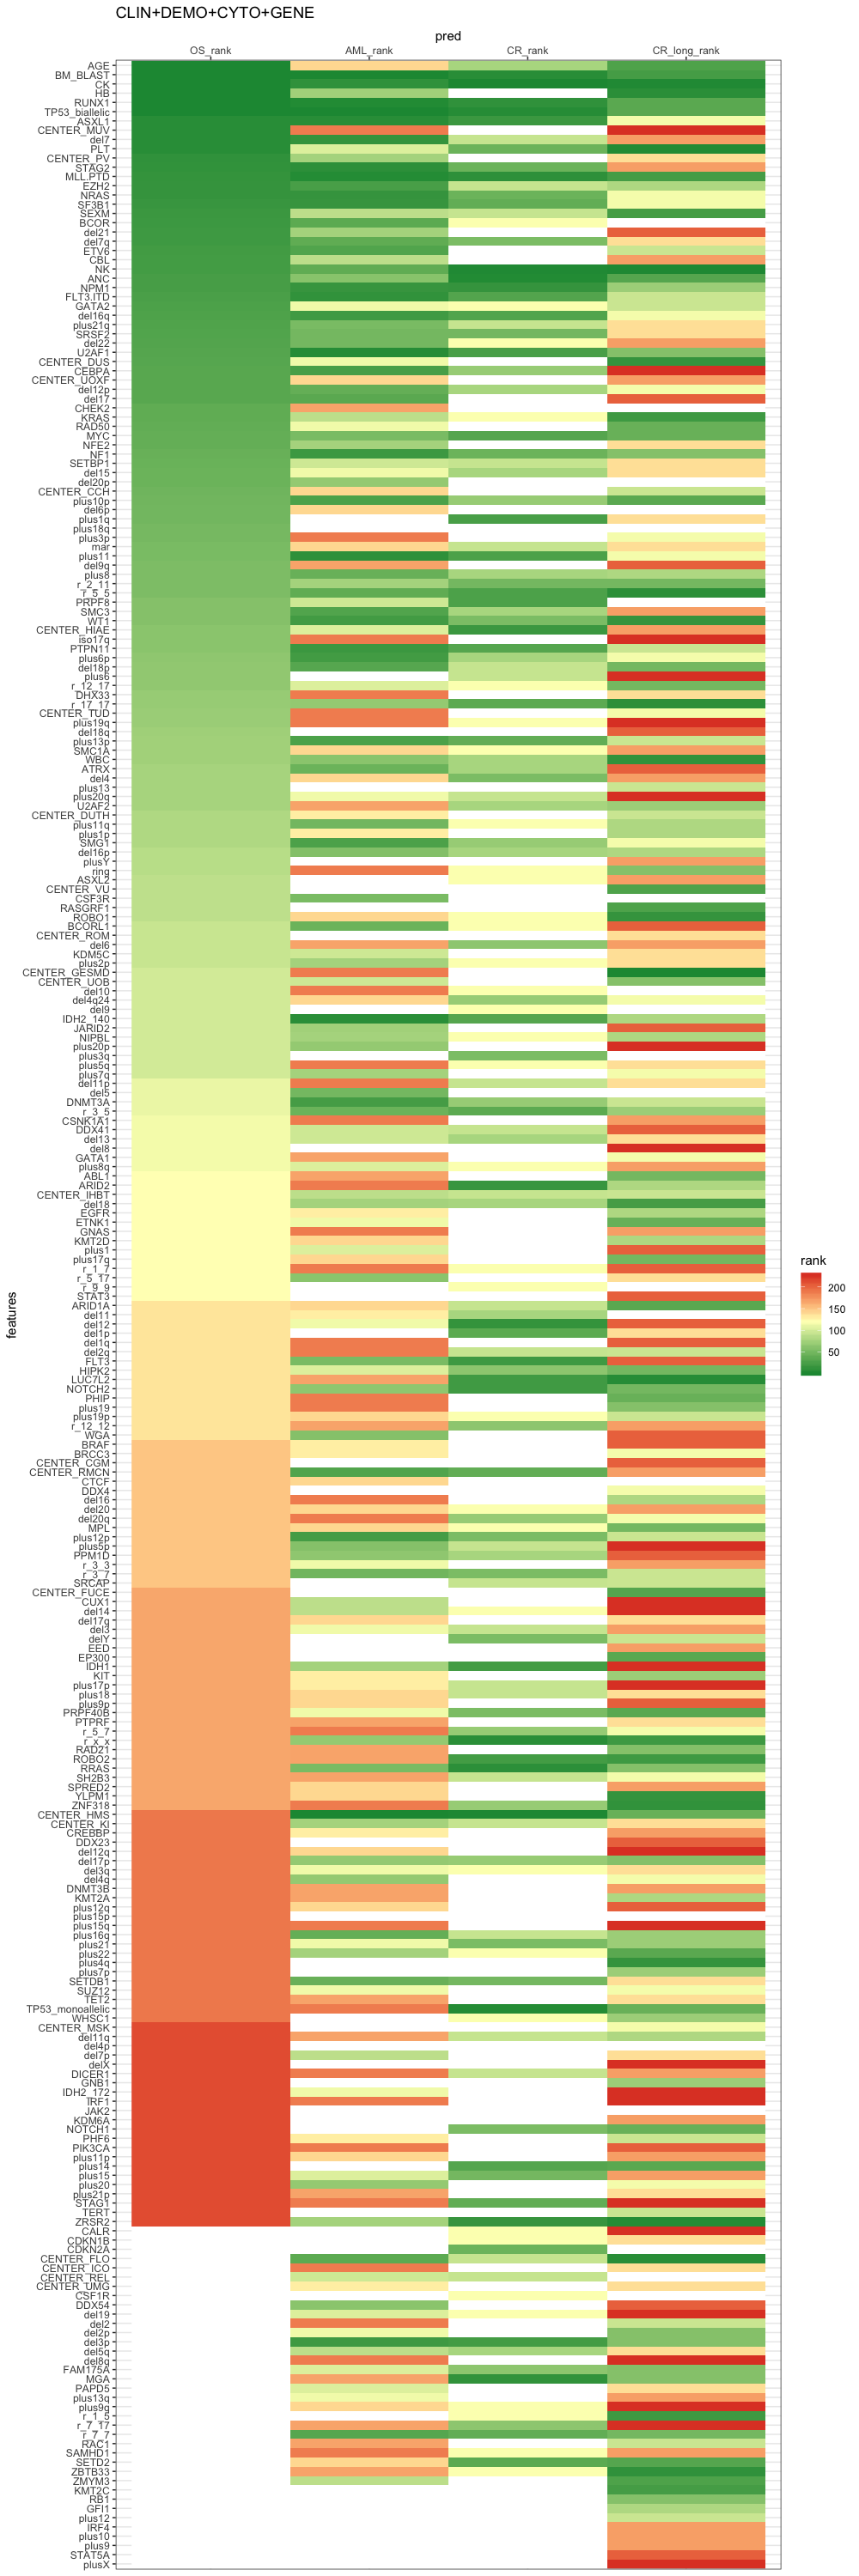

In [9]:
set_notebook_plot_size(10,30)
ggplot(CLIN_DEMO_CYTO_GENE_ranking, aes(features,pred)) +
  
  # geom raster heatmap
  geom_raster(aes(fill = rank), show.legend = TRUE) +
  scale_fill_gradient2(low="#1a9641", high="#d7191c",mid = "#ffffbf",midpoint=121,na.value = 'white') +
  scale_y_discrete(position = "right") +
  #theme(axis.text.x.top = element_text(angle = 30, hjust = 1)) +
  coord_flip() +
  ggtitle('CLIN+DEMO+CYTO+GENE')


Some strange features are highly selected in the competing risks and not in the overall survival neither in the AML transformation, like ZBTB33, r_1_5, LUC7L2, and important features are absent, like BCOR or del7. It seems that the criteria to select features for competing risks is not adapted to the dataset we have.

The competing risks version using the same lambda for all bootstrap experiments gives bias results, the long version should be prefered. However the strange features that are selected by this method brings us to go deeper to understand what is going on.

First, we will look at the range of the lambdas selected in each bootstrap.


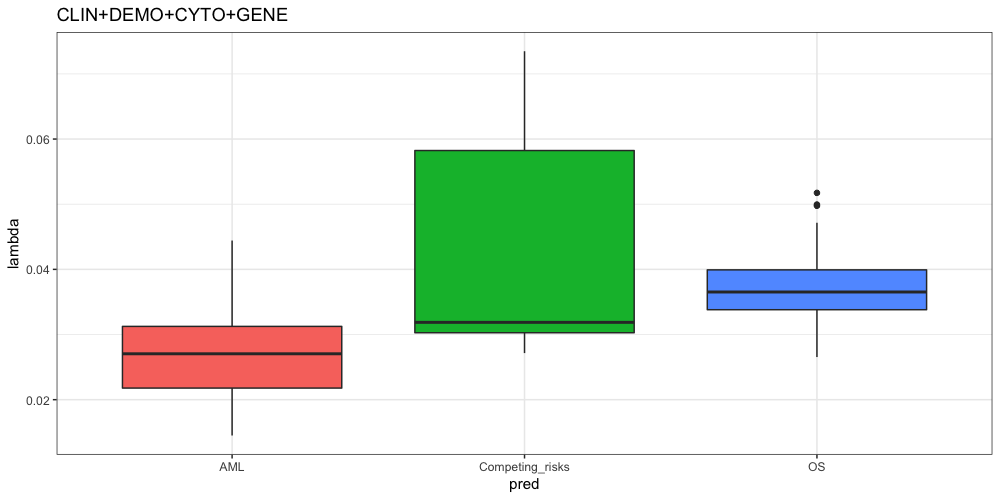

In [12]:
set_notebook_plot_size(10,5)
CLIN_DEMO_CYTO_GENE_OS_AML_CR_lambda<-rbind(read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_OS_AML_CR_lambda.tsv',sep='\t')[1:200,],
                                       read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_CR_lambda.tsv',sep='\t'))

  

ggplot(CLIN_DEMO_CYTO_GENE_OS_AML_CR_lambda,aes(x=pred,y=lambda))+
  geom_boxplot(aes(fill=pred),notch = F) +
  theme(legend.position = "none") +
  ggtitle('CLIN+DEMO+CYTO+GENE')


The range of the lambdas selected is really wider for competing risks than for overall survival and AML transformation.

Let's look more closely at one experiment to understand what is happening:

In [4]:
# -------------- DATA -------------- #
# CLINICAL DF
ddc = read.table("../../data/updated_dataset/df_clinical_cyto_selected_process_ippsr.tsv",stringsAsFactors=F,header=T,sep="\t")
# MUTATIONS MAF
ddmaf = read.table("../../data/updated_dataset/df_maf_driver_selected.tsv",stringsAsFactors=F,header=T,sep="\t")
# CYTO DF
ddcyto = read.table("../../data/updated_dataset/df_cyto_binary_impute.tsv",stringsAsFactors=F,header=T,sep="\t")
# COMPONENTS DF
#ddcomponents = read.table("../../data/updated_dataset/df_components.tsv",stringsAsFactors=F,header=T,sep="\t")
# GENE INTERACTION DF
#ddint_double = read.table("../../data/updated_dataset/datagene_interactions_duplicate_cut1_v2.tsv",stringsAsFactors=F,header=T,sep="\t")
#ddint_triple = read.table("../../data/updated_dataset/datagene_interactions_triplicate_cut2_v2.tsv",stringsAsFactors=F,header=T,sep="\t")
# ---------------------------------- #
if(identical(ddc$LEUKID,ddcyto$LEUKID)) print("all good")
# CREATE MUTATIONS DF
res = merge_clinical_mutation(dd_clinical=ddc, dd_maf=ddmaf, binary=FALSE, col_field="EVENT")
#dd = res$ddmerge # merge
#ddmut = res$ddmut # binary mutation matrix
#if(identical(ddc$LEUKID,rownames(ddmut))) print("all good ^ 2")
# ---------------------------------- #
# ADD METRIC
ddc$AGE = round(ddc$AGE_AT_SAMPLE_TIME)
# -> number of cyto aberrations
ddcyto.reduce = ddcyto[,-which(colnames(ddcyto)%in%c("LEUKID","del4q24"))]
ddc$num_cyto_aberrations = apply(ddcyto.reduce,1,sum)
# -> correct for r_1_7
j17 = which(ddcyto[,"r_1_7"]==1 & ddcyto[,"plus1q"]==1 & ddcyto[,"del7q"]==1)
ddc$num_cyto_aberrations[j17] = ddc$num_cyto_aberrations[j17] - 1
# -> correct for iso17q
jiso17 = which(ddcyto[,"iso17q"]==1 & ddcyto[,"del17p"]==1 & ddcyto[,"plus17q"]==1)
ddc$num_cyto_aberrations[jiso17] = ddc$num_cyto_aberrations[jiso17] - 1
# -> total number of mutations + del4q24
ddc$num_mutations = apply(res$ddmut,1,sum) + ddcyto[,"del4q24"]
## competing risks
ddc$time<-with(ddc,ifelse(aml_status==0,os_diag_years,aml_diag_years))
ddc$fstatus<-with(ddc,ifelse(aml_status==0,2*os_status,1))
# ---------------------------------- #
# GET READY DATAFRAMES FOR PREDICTIONS
# ddc is clinical df
# ddmutation
ddmut5 = read.table("../../data/updated_dataset/df_mut_hotspot_cut5.tsv", stringsAsFactors=F, header=T, sep="\t")
# cyto with features NK and CK
ddcyto5 = read.table("../../data/updated_dataset/df_cyto_binary_impute_cut5.tsv", stringsAsFactors=F, header=T, sep="\t")
id <-ddcyto5[,1]
rownames(ddcyto5)<-id
ddcyto5<-ddcyto5[ddc$LEUKID,]
ddcyto5 = ddcyto5[,-1]
ddcyto5$NK = 0
ddcyto5$NK[ddc$num_cyto_aberrations==0] = 1
ddcyto5$CK = 0
ddcyto5$CK[ddc$num_cyto_aberrations>=3] = 1
# ---------------------------------- #
# WITH TP53 ALLELIC STATUS
ddtp53 = read.table("../../data/updated_dataset/LEUKID_P53_status.tsv",sep="\t",header=T,stringsAsFactors=F)
rownames(ddtp53) = ddtp53$LEUKID ; ddtp53 = ddtp53[,-1]
ddtp53 = ddtp53[ddc$LEUKID,]
ddmut5[,"TP53"] = NULL
rownames(ddmut5)<-id
ddmut5<-ddmut5[ddc$LEUKID,]
ddmut5 = cbind(ddmut5,ddtp53)
ddmut5[,"U2AF1"]=ddmut5[,"U2AF1_157"]+ddmut5[,"U2AF1_34"]
ddmut5[,"U2AF1_157"]=NULL
ddmut5[,"U2AF1_34"]=NULL

rec<-colSums(ddcyto5)
rec<-rec[1:(length(rec)-2)]
rec<-sort(rec,decreasing = T)
rec<-rec[1:10]
rec<-names(rec)
# ---------------------------------- #

# ---------------------------------- #
# DEFINE FEATURE GROUPS
# ---------------------------------- #
nuisance = c("CENTER")
ipssr = c("AGE","HB","PLT","ANC","BM_BLAST","CYTO_IPSSR","IPSSR_CALCULATED")
clinicalother = c("SEX")
mutnumber = c("num_mutations")
cytonumber = c("num_cyto_aberrations")
mutations = colnames(ddmut5)
cytoaberrations = colnames(ddcyto5)
age=c("AGE")
ipssr.score=c("IPSSR_CALCULATED")
ipssr.wt.score = c("AGE","HB","PLT","ANC","BM_BLAST","CYTO_IPSSR")
wbc=c("WBC")
#geneint_double=colnames(ddint_double)
#geneint_triple=colnames(ddint_triple)
clin=c("HB","PLT","ANC","BM_BLAST")
#component=c("component")
topcyto=c(rec,"CK","NK")
blast=c("BM_BLAST")

list.features = list(nuisance=nuisance,
                     ipssr=ipssr,
                     clinicalother=clinicalother,
                     mutnumber=mutnumber,
                     cytonumber=cytonumber,
                     mutations=mutations,
                     cytoaberrations=cytoaberrations,
                     age=age,
                     ipssr.score=ipssr.score,
                     ipssr.wt.score=ipssr.wt.score,
                     wbc=wbc,
                     #geneint_double=geneint_double,
                     #geneint_triple=geneint_triple,
                     clin=clin,
                     #component=component,
                     topcyto=topcyto,
                     blast=blast)

# ---------------------------------- #
# COMPLETE CASE FOR OS
# ---------------------------------- #
# COMPLETE CASE WITH OS AND AML RESPONSE 
i.complete = which(ddc$ipssr_complete_case=="complete")
response.name1 = c("os_diag_years","os_status")
tmp = ddc[i.complete,response.name1]
i.survival = i.complete[-which(tmp[,1]<=0 | is.na(tmp[,1]) | is.na(tmp[,2]))]
#ddcomponents = ddcomponents[as.character(ddc$LEUKID),]
ddgo = cbind(ddc,ddmut5,ddcyto5)
#ddgo$component=ddcomponents
ddgo = ddgo[i.survival,]
#ddgo = cbind(ddgo,ddint_double,ddint_triple)


response.name2 = c("aml_diag_years","aml_status")
i.not.aml = which(ddgo$WHO_2016_SIMPLIFY_2!="AML")
tmp2 = ddgo[i.not.aml,response.name2]
i.competing.risks = i.not.aml[-which(tmp2[,1]<=0 | is.na(tmp2[,1]) | is.na(tmp2[,2]))]

ddgo = ddgo[i.competing.risks,]

response.name3 = c("time","fstatus")

ddgo = ddgo[,c(unlist(list.features),response.name1,response.name2,response.name3)] 

ddgo[is.na(ddgo[, "WBC"]), "WBC"] <- mean(ddgo[, "WBC"], na.rm = TRUE) # MEAN IMPUTATION FOR WBC MISSING
ddgo$CENTER <- paste0('_', ddgo$CENTER)

[1] "all good"


In [5]:
models <- list()

models[['CLIN_DEMO_CYTO']] <- c(nuisance,clinicalother,wbc,age,clin,cytoaberrations)
models[['CLIN_DEMO_CYTO_GENE']] <- c(nuisance,clinicalother,wbc,age,clin,mutations,cytoaberrations)


In [15]:
# Competing risks function
crrp2 <- function(time, fstatus, X, failcode=1, cencode=0,
                 penalty=c("MCP", "SCAD", "LASSO"), gamma=switch(penalty, SCAD=3.7, 2.7), 
                 alpha=1, lambda.min=.001, nlambda=50, lambda, eps=.001, 
                 max.iter=1000, penalty.factor=rep(1, ncol(X)), weighted=FALSE){
  
  dpenalty <- function(beta, gamma=switch(penalty, SCAD=3.7, 2.7), lambda, penalty=c("LASSO", "SCAD", "MCP"),
                       penalty.factor=rep(1, length(beta))){
    penalty <- match.arg(penalty)
    m <- penalty.factor
    ans <- rep(NA, length(beta))
    if (penalty=="LASSO"){
      ans[abs(beta) > 0] = (abs(beta[abs(beta) > 0])*m[abs(beta)>0])^{-1}
      ans[beta==0]=0
      w <- diag(as.vector(ans))
      ww <- w*lambda
      return(ww)
    }
    else if (penalty=="SCAD"){
      ans[abs(beta) > 0]=(lambda*(abs(beta[abs(beta) > 0])<=lambda)+
                            pmax(gamma*lambda-abs(beta[abs(beta) > 0]), 0)/(gamma-1)*(abs(beta[abs(beta) > 0])>lambda))/abs(beta[abs(beta) > 0])
      ans[beta==0]=0
      return(diag(as.vector(ans)))
    }
    else if (penalty=="MCP"){
      ans[abs(beta)>0]=1*(abs(beta[abs(beta) > 0])<=gamma*lambda)*(lambda-abs(beta[abs(beta) > 0])/gamma)/abs(beta[abs(beta) > 0])
      ans[beta==0]=0
      return(diag(as.vector(ans)))
      
    }
  }
  
  ginv = function(X, tol = sqrt(.Machine$double.eps)){
    s = svd(X)
    nz = s$d > tol * s$d[1]
    if(any(nz)) s$v[,nz] %*% (t(s$u[,nz])/s$d[nz])
    else X*0
  }
  
  ##sort time
  n <- length(time)
  p <- ncol(X)
  d <- data.frame(time=time, fstatus=fstatus)
  if (!missing(X)) d$X <- as.matrix(X)
  d <- d[order(d$time),]
  ftime <- d$time
  cenind <- ifelse(d$fstatus==cencode,1,0)
  fstatus <- ifelse(d$fstatus==failcode, 1,2*(1-cenind))
  X <- d$X
  u <- do.call('survfit',list(formula=Surv(ftime,cenind)~1,data=data.frame(ftime,cenind)))  
  #### uuu is weight function
  u <- approx(c(0,u$time,max(u$time)*(1+10*.Machine$double.eps)),c(1,u$surv,0),
              xout=ftime*(1-100*.Machine$double.eps),method='constant',f=0,rule=2)
  uuu <- u$y
  #end of data preparation##################################################
  #Output time, fstatus, uuu, X
  
  ## Error checking
  if (gamma <= 1 & penalty=="MCP") stop("gamma must be greater than 1 for the MC penalty")
  if (gamma <= 2 & penalty=="SCAD") stop("gamma must be greater than 2 for the SCAD penalty")
  if (nlambda < 2) stop("nlambda must be at least 2")
  if (alpha <= 0) stop("alpha must be greater than 0; choose a small positive number instead")
  if (length(penalty.factor)!=ncol(X)) stop("penalty.factor does not match up with X")
  
  ## Set up XX, yy, lambda
  std <- .Call("standardize", X, PACKAGE="crrp")
  XX <- std[[1]]
  center <- std[[2]]
  scale <- std[[3]]
  
  if (weighted) penalty.factor <- penalty.factor*scale
  
  nz <- which(scale > 1e-6)
  if (length(nz) != ncol(XX)) XX <- XX[ ,nz, drop=FALSE]
  penalty.factor <- penalty.factor[nz]
  
  # initial value
  #set value of lambda
  if (missing(lambda)) {
    eta0 <- rep(0,n)  
    sw <- .C("scorehessian", as.double(ftime),as.integer(fstatus), as.double(XX),
             as.integer(p), as.integer(n),  as.double(uuu), as.double(eta0), 
             double(n), double(n), double(1), PACKAGE="crrp")
    score0 <- sw[[8]]
    w0 <- sw[[9]]
    r0 <- ifelse(w0==0, 0, score0/w0)
    z <- eta0+r0
    l.max <- max(t(w0*z)%*%XX)/n
    l.min <- lambda.min
    lambda=exp(seq(log(l.max),log(l.min*l.max),len=nlambda)) 
    user.lambda <- FALSE
  } else {
    nlambda <- length(lambda)
    user.lambda <- TRUE
  }
  
  ## Fit
  
  res <- .Call("cdfit_psh", XX, as.numeric(ftime), as.integer(fstatus), uuu, penalty, lambda, 
               eps, as.integer(max.iter), gamma, penalty.factor, alpha, PACKAGE="crrp")
  b <- matrix(res[[1]], p, (nlambda))
  dev <- res[[2]]
  iter <- res[[3]]  
  score <- matrix(res[[5]], n, nlambda)
  hessian <- matrix(res[[6]], n, nlambda)  
  ## Unstandardize
  beta <- b/scale  
  ## Names
  if (is.null(colnames(X))) varnames <- paste("V",1:ncol(X),sep="")
  else varnames <- colnames(X)
  colnames(beta) <-  round(lambda,digits=4)
  rownames(beta) <- varnames
  
  #calculate GCV, BIC, and standard error
  sd <- matrix(0, p, nlambda)
  bic <- gcv <- ps <- rep(0, nlambda)
  for ( l in 1:nlambda){
    #zwz <- t(XX)%*%diag(hessian[,l])%*%XX
    #pp <- dpenalty(beta=b[,l ],lambda=lambda[l], penalty=penalty, penalty.factor=penalty.factor)
    #sd[,l ] <- sqrt(diag(ginv(zwz+n*pp)%*%zwz%*%ginv(zwz+n*pp)))/scale
    
    ll <-dev[l]/-2
    bic[l] <- -2*ll+sum(1-(b[,l ]==0))*log(n)
    
    #ps[l] <- sum(diag(XX%*%ginv(zwz+n*pp)%*%t(XX)%*%diag(hessian[,l])))-sum(b[,l ] == 0)
    #gcv[l] = -ll/(n*(1-ps[l]/n)^2)
    sd[l]<-NA
    gcv[l]<-NA
  }
  
  ## Output
  val <- structure(list(beta = beta,
                        iter = iter,
                        lambda = lambda,
                        penalty = penalty,
                        gamma = gamma,
                        alpha = alpha,
                        loglik = ll,
                        GCV = gcv,
                        BIC = bic,
                        SE=sd,
                        call=sys.call()),
                   class = "crrp")
  
  val
  
}


In [19]:
# One run 

model <- 'CLIN_DEMO_CYTO_GENE'

formula <- paste(models[[model]], collapse = '+')
formula <- paste0('~ 0 +', formula)

x <- model.matrix(as.formula(formula), ddgo[, models[[model]]])
y <- ddgo[, c("time","fstatus")]

colnames(y) <- c('time', 'status')
y <- as.matrix(y)

set.seed(1234)
s<-sample( 0.8 * nrow(ddgo), replace = TRUE)

xtrain <- x[s,]
xtest <- x[-s,]
ytrain <- y[s,]
ytest <- y[-s,]


cvfit <- crrp2(ytrain[,1],
               ytrain[,2],
               xtrain,
               penalty = 'LASSO',
               nlambda=50,
               max.iter=500,
               alpha = 1)

tmp <- data.frame(coef=cvfit$beta[,which.min(cvfit$BIC)])

Warning message in matrix(res[[1]], p, (nlambda)):
“data length [13200] is not a sub-multiple or multiple of the number of rows [272]”

In [20]:
rownames(tmp)[which(tmp$coef!=0)]


[1] "del17p"

We find that for the best lambda using BIC, only one feature is selected. After performing a longer study, it seems that the BIC gives biased results for this dataset, returning often models with very few features selected. It seems that the penalization term introduced by the BIC, counting the number of non null features, has a too strong influence with this dataset.



# Generalized cross validation (GCV)
Same method used for the BIC, but the generalized cross validation metric is prefered.

In [85]:
# Competing risks function
crrp2 <- function(time, fstatus, X, failcode=1, cencode=0,
                 penalty=c("MCP", "SCAD", "LASSO"), gamma=switch(penalty, SCAD=3.7, 2.7), 
                 alpha=1, lambda.min=.001, nlambda=50, lambda, eps=.001, 
                 max.iter=1000, penalty.factor=rep(1, ncol(X)), weighted=FALSE){
  
  dpenalty <- function(beta, gamma=switch(penalty, SCAD=3.7, 2.7), lambda, penalty=c("LASSO", "SCAD", "MCP"),
                       penalty.factor=rep(1, length(beta))){
    penalty <- match.arg(penalty)
    m <- penalty.factor
    ans <- rep(NA, length(beta))
    if (penalty=="LASSO"){
      ans[abs(beta) > 0] = (abs(beta[abs(beta) > 0])*m[abs(beta)>0])^{-1}
      ans[beta==0]=0
      w <- diag(as.vector(ans))
      ww <- w*lambda
      return(ww)
    }
    else if (penalty=="SCAD"){
      ans[abs(beta) > 0]=(lambda*(abs(beta[abs(beta) > 0])<=lambda)+
                            pmax(gamma*lambda-abs(beta[abs(beta) > 0]), 0)/(gamma-1)*(abs(beta[abs(beta) > 0])>lambda))/abs(beta[abs(beta) > 0])
      ans[beta==0]=0
      return(diag(as.vector(ans)))
    }
    else if (penalty=="MCP"){
      ans[abs(beta)>0]=1*(abs(beta[abs(beta) > 0])<=gamma*lambda)*(lambda-abs(beta[abs(beta) > 0])/gamma)/abs(beta[abs(beta) > 0])
      ans[beta==0]=0
      return(diag(as.vector(ans)))
      
    }
  }
  
  ginv = function(X, tol = sqrt(.Machine$double.eps)){
    s = svd(X)
    nz = s$d > tol * s$d[1]
    if(any(nz)) s$v[,nz] %*% (t(s$u[,nz])/s$d[nz])
    else X*0
  }
  
  ##sort time
  n <- length(time)
  p <- ncol(X)
  d <- data.frame(time=time, fstatus=fstatus)
  if (!missing(X)) d$X <- as.matrix(X)
  d <- d[order(d$time),]
  ftime <- d$time
  cenind <- ifelse(d$fstatus==cencode,1,0)
  fstatus <- ifelse(d$fstatus==failcode, 1,2*(1-cenind))
  X <- d$X
  u <- do.call('survfit',list(formula=Surv(ftime,cenind)~1,data=data.frame(ftime,cenind)))  
  #### uuu is weight function
  u <- approx(c(0,u$time,max(u$time)*(1+10*.Machine$double.eps)),c(1,u$surv,0),
              xout=ftime*(1-100*.Machine$double.eps),method='constant',f=0,rule=2)
  uuu <- u$y
  #end of data preparation##################################################
  #Output time, fstatus, uuu, X
  
  ## Error checking
  if (gamma <= 1 & penalty=="MCP") stop("gamma must be greater than 1 for the MC penalty")
  if (gamma <= 2 & penalty=="SCAD") stop("gamma must be greater than 2 for the SCAD penalty")
  if (nlambda < 2) stop("nlambda must be at least 2")
  if (alpha <= 0) stop("alpha must be greater than 0; choose a small positive number instead")
  if (length(penalty.factor)!=ncol(X)) stop("penalty.factor does not match up with X")
  
  ## Set up XX, yy, lambda
  std <- .Call("standardize", X, PACKAGE="crrp")
  XX <- std[[1]]
  center <- std[[2]]
  scale <- std[[3]]
  
  if (weighted) penalty.factor <- penalty.factor*scale
  
  nz <- which(scale > 1e-6)
  if (length(nz) != ncol(XX)) XX <- XX[ ,nz, drop=FALSE]
  penalty.factor <- penalty.factor[nz]
  
  # initial value
  #set value of lambda
  if (missing(lambda)) {
    eta0 <- rep(0,n)  
    sw <- .C("scorehessian", as.double(ftime),as.integer(fstatus), as.double(XX),
             as.integer(p), as.integer(n),  as.double(uuu), as.double(eta0), 
             double(n), double(n), double(1), PACKAGE="crrp")
    score0 <- sw[[8]]
    w0 <- sw[[9]]
    r0 <- ifelse(w0==0, 0, score0/w0)
    z <- eta0+r0
    l.max <- max(t(w0*z)%*%XX)/n
    l.min <- lambda.min
    lambda=exp(seq(log(l.max),log(l.min*l.max),len=nlambda)) 
    user.lambda <- FALSE
  } else {
    nlambda <- length(lambda)
    user.lambda <- TRUE
  }
  
  ## Fit
  
  res <- .Call("cdfit_psh", XX, as.numeric(ftime), as.integer(fstatus), uuu, penalty, lambda, 
               eps, as.integer(max.iter), gamma, penalty.factor, alpha, PACKAGE="crrp")
  b <- matrix(res[[1]], p, (nlambda))
  dev <- res[[2]]
  iter <- res[[3]]  
  score <- matrix(res[[5]], n, nlambda)
  hessian <- matrix(res[[6]], n, nlambda)  
  ## Unstandardize
  beta <- b/scale  
  ## Names
  if (is.null(colnames(X))) varnames <- paste("V",1:ncol(X),sep="")
  else varnames <- colnames(X)
  colnames(beta) <-  round(lambda,digits=4)
  rownames(beta) <- varnames
  
  #calculate GCV, BIC, and standard error
  sd <- matrix(0, p, nlambda)
  bic <- gcv <- ps <- rep(0, nlambda)
  for ( l in 1:nlambda){
    
    zwz <- t(XX)%*%diag(hessian[,l])%*%XX
    pp <- dpenalty(beta=b[,l ],lambda=lambda[l], penalty=penalty, penalty.factor=penalty.factor)
    #sd[,l ] <- sqrt(diag(ginv(zwz+n*pp)%*%zwz%*%ginv(zwz+n*pp)))/scale
    
    ll <-dev[l]/-2
    #bic[l] <- -2*ll+sum(1-(b[,l ]==0))*log(n)

    ps[l] <- sum(diag(XX%*%ginv(zwz+n*pp)%*%t(XX)%*%diag(hessian[,l])))-sum(b[,l ] == 0)
    gcv[l] = -ll/(n*(1-ps[l]/n)^2)
    
  }
  
  ## Output
  val <- structure(list(beta = beta,
                        iter = iter,
                        lambda = lambda,
                        penalty = penalty,
                        gamma = gamma,
                        alpha = alpha,
                        loglik = ll,
                        GCV = gcv,
                        BIC = bic,
                        SE=sd,
                        call=sys.call()),
                   class = "crrp")
  
  val
  
}


When working with GCV, the way the package is written returns errors when one feature of the initial dataset has a very low standard deviation (< 1e-6) when computing the GCV. This case often happens when doing bootstrapping because of sampling. To avoid that, the `crrp_wrap` function bellow removes those features so `crrp2` can work on it, and then they are added to the model found with null coefficients. No bias is created by removing those unimportant features.

In [86]:
crrp_wrap <- function(time, fstatus, X, failcode=1, cencode=0,
                 penalty=c("MCP", "SCAD", "LASSO"), gamma=switch(penalty, SCAD=3.7, 2.7), 
                 alpha=1, lambda.min=.001, nlambda=50, lambda, eps=.001, 
                 max.iter=1000, penalty.factor=rep(1, ncol(X)), weighted=FALSE){
    
    nini <- ncol(X)
    xnames <- colnames(X)
    
    std <- .Call("standardize", X, PACKAGE="crrp")
    scale <- std[[3]]
    nz <- which(scale > 1e-6) #columns that will be removed to run crrp2
    
    X2 <- X[,nz]
    colnames(X2)<-colnames(X)[nz]
    
    crrp_res <- crrp2(time, fstatus, X2, failcode=failcode, cencode=cencode,
                 penalty=penalty, gamma=gamma, 
                 alpha=alpha, lambda.min=lambda.min, nlambda=nlambda, lambda, eps=eps, 
                 max.iter=max.iter, penalty.factor=rep(1, ncol(X2)), weighted=weighted)
    
    beta2<-matrix(0, nrow=nini, ncol=nlambda)
    for(i in 1:length(nz)){
        beta2[nz[i],]<-crrp_res$beta[i,]
    }
    rownames(beta2) <- xnames
    
    ## Output
    val <- structure(list(beta = beta2,
                        iter = crrp_res$iter,
                        lambda = crrp_res$lambda,
                        penalty = crrp_res$penalty,
                        gamma = crrp_res$gamma,
                        alpha = crrp_res$alpha,
                        loglik = crrp_res$loglik,
                        GCV = crrp_res$GCV,
                        BIC = crrp_res$BIC,
                        SE=crrp_res$SE,
                        call=sys.call()),
                   class = "crrp")
  
    val
    
}


In [87]:
# One run 

model <- 'CLIN_DEMO_CYTO_GENE'

formula <- paste(models[[model]], collapse = '+')
formula <- paste0('~ 0 +', formula)

x <- model.matrix(as.formula(formula), ddgo[, models[[model]]])
y <- ddgo[, c("time","fstatus")]

colnames(y) <- c('time', 'status')
y <- as.matrix(y)

set.seed(1234)
s<-sample( 0.8 * nrow(ddgo), replace = TRUE)

xtrain <- x[s,]
xtest <- x[-s,]
ytrain <- y[s,]
ytest <- y[-s,]


cvfit <- crrp_wrap(ytrain[,1],
               ytrain[,2],
               xtrain,
               penalty = 'LASSO',
               nlambda=5,
               max.iter=50,
               alpha = 1)

tmp <- data.frame(coef=cvfit$beta[,which.min(cvfit$GCV)])

In [88]:
t(rownames(tmp)[which(tmp$coef!=0)])

[,1]       [,2]       [,3]       [,4]        [,5]        [,6]      
[1,] CENTER_CCH CENTER_DUS CENTER_FLO CENTER_FUCE CENTER_HIAE CENTER_HMS
     [,7]       [,8]       [,9]      [,10] [,11] [,12] [,13] [,14] [,15]   
[1,] CENTER_MSK CENTER_MUV CENTER_PV SEXM  WBC   AGE   HB    PLT   BM_BLAST
     [,16] [,17]  [,18] [,19] [,20] [,21] [,22] [,23]  [,24] [,25] [,26] [,27] 
[1,] ABL1  ARID1A ARID2 ASXL1 ASXL2 ATRX  BCOR  BCORL1 BRAF  BRCC3 CBL   CDKN1B
     [,28] [,29]  [,30] [,31] [,32] [,33] [,34] [,35] [,36] [,37]  [,38] 
[1,] CEBPA CREBBP CSF1R CSF3R CUX1  DDX23 DDX41 DDX54 DHX33 DICER1 DNMT3A
     [,39]  [,40] [,41] [,42] [,43] [,44]   [,45]    [,46] [,47] [,48] [,49]
[1,] DNMT3B EED   EGFR  EP300 ETNK1 FAM175A FLT3.ITD GATA1 GATA2 GNB1  HIPK2
     [,50] [,51]    [,52]    [,53] [,54]  [,55] [,56] [,57] [,58] [,59]  [,60]
[1,] IDH1  IDH2_140 IDH2_172 JAK2  JARID2 KDM5C KDM6A KMT2D KRAS  LUC7L2 MGA  
     [,61]   [,62] [,63] [,64] [,65] [,66] [,67]  [,68] [,69] [,70] [,71]
[1,] MLL.PTD MPL   MYC   NF1   NFE2  NIPBL NOTCH2 NPM1  NRAS  PAPD5 PHIP 
     [,72]  [,73]   [,74] [,75]  [,76] [,77] [,78] [,79] [,80]   [,81] [,82]
[1,] PIK3CA PRPF40B PRPF8 PTPN11 PTPRF RAC1  RAD21 RAD50 RASGRF1 ROBO1 RRAS 
     [,83] [,84]  [,85]  [,86] [,87] [,88] [,89] [,90]  [,91] [,92] [,93] 
[1,] RUNX1 SETBP1 SETDB1 SF3B1 SH2B3 SMC3  SMG1  SPRED2 SRSF2 STAG2 STAT5A
     [,94] [,95] [,96] [,97] [,98] [,99] [,100] [,101] [,102] [,103]
[1,] SUZ12 TERT  U2AF2 WHSC1 WT1   YLPM1 ZBTB33 ZMYM3  ZNF318 ZRSR2 
     [,104]           [,105]         [,106] [,107] [,108] [,109] [,110] [,111]
[1,] TP53_monoallelic TP53_biallelic U2AF1  del5q  plus8  delY   mar    del7q 
     [,112]  [,113] [,114] [,115] [,116] [,117] [,118] [,119] [,120] [,121]
[1,] del4q24 del11q del18  plus21 del3p  del17  del15  del1p  del16q del5  
     [,122] [,123] [,124]  [,125] [,126] [,127] [,128] [,129] [,130] [,131]
[1,] del21  plus19 plus17q del9q  plus22 plus14 plus11 del14  del22  delX  
     [,132] [,133] [,134] [,135] [,136] [,137] [,138] [,139] [,140] [,141]
[1,] r_3_3  del11p del3   plus5p del4q  del3q  plus9  plus1  plus13 del2p 
     [,142] [,143] [,144] [,145] [,146]  [,147] [,148]  [,149] [,150] [,151] 
[1,] plus7q ring   del2q  del4   plus12p del6   plus19p plus9p del17q plus19q
     [,152]  [,153] [,154] [,155] [,156] [,157] [,158]  [,159] [,160] [,161]
[1,] plus21q plus2p plus6p plusX  del12q plus10 plus20p del16p del19  iso17q
     [,162] [,163] [,164] [,165] [,166] [,167] [,168]  [,169] [,170] [,171]
[1,] plus6  plus9q del10  del11  del6q  del8   plus15p plus8q del18q del8q 
     [,172] [,173]  [,174]  [,175] [,176] [,177] [,178] [,179] [,180]  [,181] 
[1,] plus18 plus18q r_12_17 r_3_7  del18p plus12 r_3_5  r_7_7  plus10p plus16q
     [,182] [,183]  [,184] [,185]  [,186]
[1,] plus20 plus21p plus4q r_17_17 r_x_x

In [121]:
tmp <- cvfit$beta[,which.min(cvfit$GCV)]

This version of the package works for most cases, but for some samples of the dataset errors are returned:

In [125]:
# Sampling
set.seed(1234)
n_experiment=100
formula <- paste(models[['CLIN_DEMO_CYTO_GENE']], collapse = '+')
formula <- paste0('~ 0 +', formula)

x <- model.matrix(as.formula(formula), ddgo[, models[['CLIN_DEMO_CYTO_GENE']]])
y <- ddgo[, c("time","fstatus")]

colnames(y) <- c('time', 'status')
y <- as.matrix(y)


n = nrow(ddgo)
folds <- list()
for (i in seq(n_experiment)) {
  folds[[i]] <- sample(1:n, 0.8 * n, replace = TRUE)
}
nexp = length(folds)


In [126]:
# Problematic sample

x_sampling78 = x[folds[[78]],]
y_sampling78 = y[folds[[78]],]

# Remove empty features
ini <- ncol(x_sampling78)
xnames <- colnames(x_sampling78)

std <- .Call("standardize", x_sampling78, PACKAGE="crrp")
scale <- std[[3]]
nz <- which(scale > 1e-6) #columns that will be removed to run crrp

X <- x_sampling78[,nz]
colnames(X)<-colnames(x_sampling78)[nz]


In [127]:
# Function to visualize the error
crrp3 <- function(time, fstatus, X, failcode=1, cencode=0,
                  penalty=c("MCP", "SCAD", "LASSO"), gamma=switch(penalty, SCAD=3.7, 2.7), 
                  alpha=1, lambda.min=.001, nlambda=50, lambda, eps=.001, 
                  max.iter=1000, penalty.factor=rep(1, ncol(X)), weighted=FALSE){
  
  dpenalty <- function(beta, gamma=switch(penalty, SCAD=3.7, 2.7), lambda, penalty=c("LASSO", "SCAD", "MCP"),
                       penalty.factor=rep(1, length(beta))){
    penalty <- match.arg(penalty)
    m <- penalty.factor
    ans <- rep(NA, length(beta))
    if (penalty=="LASSO"){
      ans[abs(beta) > 0] = (abs(beta[abs(beta) > 0])*m[abs(beta)>0])^{-1}
      ans[beta==0]=0
      w <- diag(as.vector(ans))
      ww <- w*lambda
      return(ww)
    }
    else if (penalty=="SCAD"){
      ans[abs(beta) > 0]=(lambda*(abs(beta[abs(beta) > 0])<=lambda)+
                            pmax(gamma*lambda-abs(beta[abs(beta) > 0]), 0)/(gamma-1)*(abs(beta[abs(beta) > 0])>lambda))/abs(beta[abs(beta) > 0])
      ans[beta==0]=0
      return(diag(as.vector(ans)))
    }
    else if (penalty=="MCP"){
      ans[abs(beta)>0]=1*(abs(beta[abs(beta) > 0])<=gamma*lambda)*(lambda-abs(beta[abs(beta) > 0])/gamma)/abs(beta[abs(beta) > 0])
      ans[beta==0]=0
      return(diag(as.vector(ans)))
      
    }
  }
  
  ginv = function(X, tol = sqrt(.Machine$double.eps)){
    s = svd(X)
    nz = s$d > tol * s$d[1]
    if(any(nz)) s$v[,nz] %*% (t(s$u[,nz])/s$d[nz])
    else X*0
  }
  
  ##sort time
  n <- length(time)
  p <- ncol(X)
  d <- data.frame(time=time, fstatus=fstatus)
  if (!missing(X)) d$X <- as.matrix(X)
  d <- d[order(d$time),]
  ftime <- d$time
  cenind <- ifelse(d$fstatus==cencode,1,0)
  fstatus <- ifelse(d$fstatus==failcode, 1,2*(1-cenind))
  X <- d$X
  u <- do.call('survfit',list(formula=Surv(ftime,cenind)~1,data=data.frame(ftime,cenind)))  
  #### uuu is weight function
  u <- approx(c(0,u$time,max(u$time)*(1+10*.Machine$double.eps)),c(1,u$surv,0),
              xout=ftime*(1-100*.Machine$double.eps),method='constant',f=0,rule=2)
  uuu <- u$y
  #end of data preparation##################################################
  #Output time, fstatus, uuu, X
  
  ## Error checking
  if (gamma <= 1 & penalty=="MCP") stop("gamma must be greater than 1 for the MC penalty")
  if (gamma <= 2 & penalty=="SCAD") stop("gamma must be greater than 2 for the SCAD penalty")
  if (nlambda < 2) stop("nlambda must be at least 2")
  if (alpha <= 0) stop("alpha must be greater than 0; choose a small positive number instead")
  if (length(penalty.factor)!=ncol(X)) stop("penalty.factor does not match up with X")
  
  ## Set up XX, yy, lambda
  std <- .Call("standardize", X, PACKAGE="crrp")
  XX <- std[[1]]
  center <- std[[2]]
  scale <- std[[3]]
  
  if (weighted) penalty.factor <- penalty.factor*scale
  
  nz <- which(scale > 1e-6)
  if (length(nz) != ncol(XX)) XX <- XX[ ,nz, drop=FALSE]
  penalty.factor <- penalty.factor[nz]
  
  # initial value
  #set value of lambda
  if (missing(lambda)) {
    eta0 <- rep(0,n)  
    sw <- .C("scorehessian", as.double(ftime),as.integer(fstatus), as.double(XX),
             as.integer(p), as.integer(n),  as.double(uuu), as.double(eta0), 
             double(n), double(n), double(1), PACKAGE="crrp")
    score0 <- sw[[8]]
    w0 <- sw[[9]]
    r0 <- ifelse(w0==0, 0, score0/w0)
    z <- eta0+r0
    l.max <- max(t(w0*z)%*%XX)/n
    l.min <- lambda.min
    lambda=exp(seq(log(l.max),log(l.min*l.max),len=nlambda)) 
    user.lambda <- FALSE
  } else {
    nlambda <- length(lambda)
    user.lambda <- TRUE
  }
  
  ## Fit
  
  res <- .Call("cdfit_psh", XX, as.numeric(ftime), as.integer(fstatus), uuu, penalty, lambda, 
               eps, as.integer(max.iter), gamma, penalty.factor, alpha, PACKAGE="crrp")
  b <- matrix(res[[1]], p, (nlambda))
  print(head(b))
  print(lambda)
  dev <- res[[2]]
  iter <- res[[3]]  
  score <- matrix(res[[5]], n, nlambda)
  hessian <- matrix(res[[6]], n, nlambda)  
  ## Unstandardize
  beta <- b/scale  
  ## Names
  if (is.null(colnames(X))) varnames <- paste("V",1:ncol(X),sep="")
  else varnames <- colnames(X)
  colnames(beta) <-  round(lambda,digits=4)
  rownames(beta) <- varnames
  
  #calculate GCV, BIC, and standard error
  sd <- matrix(0, p, nlambda)
  bic <- gcv <- ps <- rep(0, nlambda)
  for ( l in 1:nlambda){
    
    zwz <- t(XX)%*%diag(hessian[,l])%*%XX
    pp <- dpenalty(beta=b[,l ],lambda=lambda[l], penalty=penalty, penalty.factor=penalty.factor)
    #sd[,l ] <- sqrt(diag(ginv(zwz+n*pp)%*%zwz%*%ginv(zwz+n*pp)))/scale
    
    ll <-dev[l]/-2
    #bic[l] <- -2*ll+sum(1-(b[,l ]==0))*log(n)
    
    ps[l] <- sum(diag(XX%*%ginv(zwz+n*pp)%*%t(XX)%*%diag(hessian[,l])))-sum(b[,l ] == 0)
    gcv[l] = -ll/(n*(1-ps[l]/n)^2)
    
  }
  
  ## Output
  val <- structure(list(beta = beta,
                        iter = iter,
                        lambda = lambda,
                        penalty = penalty,
                        gamma = gamma,
                        alpha = alpha,
                        loglik = ll,
                        GCV = gcv,
                        BIC = bic,
                        SE=sd,
                        call=sys.call()),
                   class = "crrp")
  
  val
  
}

In [128]:
# Run crrp with printing on this example

crrp_res <- crrp3(y_sampling78[,1], y_sampling78[,2], X,
                  penalty='LASSO', nlambda=20, 
                  max.iter=1000)

     [,1] [,2] [,3] [,4] [,5]       [,6]        [,7] [,8] [,9] [,10] [,11]
[1,]    0    0    0    0    0 0.00000000 -0.10158422  NaN  NaN   NaN   NaN
[2,]    0    0    0    0    0 0.00000000 -0.03008673  NaN  NaN   NaN   NaN
[3,]    0    0    0    0    0 0.01975896  0.00000000  NaN  NaN   NaN   NaN
[4,]    0    0    0    0    0 0.00000000  0.00000000  NaN  NaN   NaN   NaN
[5,]    0    0    0    0    0 0.02354257  0.06215814  NaN  NaN   NaN   NaN
[6,]    0    0    0    0    0 0.00000000  0.00000000  NaN  NaN   NaN   NaN
     [,12] [,13] [,14] [,15] [,16] [,17] [,18] [,19] [,20]
[1,]   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
[2,]   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
[3,]   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
[4,]   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
[5,]   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
[6,]   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
 [1] 0.1359904587 0.0945395872 0.0657232400 0.0456903230 0.031

ERROR: Error in ans[abs(beta) > 0] <- (abs(beta[abs(beta) > 0]) * m[abs(beta) > : NAs are not allowed in subscripted assignments


First, the coefficients of 6 features are printed for each value of lambda (20 values), which are printed just after. We see that for some values of lambda, the coefficients couldn't be computed and we get `NaN` for all coefficients, which returns an error after when the algorithm runs. This is *a priori* not linked to an absence of convergence of the algorithm. The origin of this error and why it happens only for some particular samples of the dataset is still unknown.

For this kind of samples, we will consider only the lambdas that returned coefficients and choose between them the one minimizing the GCV. The function `ccrp2` is modified to add the necessary code to overcome those errors.

In [ ]:
crrp2 <- function(time, fstatus, X, failcode=1, cencode=0,
                 penalty=c("MCP", "SCAD", "LASSO"), gamma=switch(penalty, SCAD=3.7, 2.7), 
                 alpha=1, lambda.min=.001, nlambda=50, lambda, eps=.001, 
                 max.iter=1000, penalty.factor=rep(1, ncol(X)), weighted=FALSE){
  
  dpenalty <- function(beta, gamma=switch(penalty, SCAD=3.7, 2.7), lambda, penalty=c("LASSO", "SCAD", "MCP"),
                       penalty.factor=rep(1, length(beta))){
    penalty <- match.arg(penalty)
    m <- penalty.factor
    ans <- rep(NA, length(beta))
    if (penalty=="LASSO"){
      ans[abs(beta) > 0] = (abs(beta[abs(beta) > 0])*m[abs(beta)>0])^{-1}
      ans[beta==0]=0
      w <- diag(as.vector(ans))
      ww <- w*lambda
      return(ww)
    }
    else if (penalty=="SCAD"){
      ans[abs(beta) > 0]=(lambda*(abs(beta[abs(beta) > 0])<=lambda)+
                            pmax(gamma*lambda-abs(beta[abs(beta) > 0]), 0)/(gamma-1)*(abs(beta[abs(beta) > 0])>lambda))/abs(beta[abs(beta) > 0])
      ans[beta==0]=0
      return(diag(as.vector(ans)))
    }
    else if (penalty=="MCP"){
      ans[abs(beta)>0]=1*(abs(beta[abs(beta) > 0])<=gamma*lambda)*(lambda-abs(beta[abs(beta) > 0])/gamma)/abs(beta[abs(beta) > 0])
      ans[beta==0]=0
      return(diag(as.vector(ans)))
      
    }
  }
  
  ginv = function(X, tol = sqrt(.Machine$double.eps)){
    s = svd(X)
    nz = s$d > tol * s$d[1]
    if(any(nz)) s$v[,nz] %*% (t(s$u[,nz])/s$d[nz])
    else X*0
  }
  
  ##sort time
  n <- length(time)
  p <- ncol(X)
  d <- data.frame(time=time, fstatus=fstatus)
  if (!missing(X)) d$X <- as.matrix(X)
  d <- d[order(d$time),]
  ftime <- d$time
  cenind <- ifelse(d$fstatus==cencode,1,0)
  fstatus <- ifelse(d$fstatus==failcode, 1,2*(1-cenind))
  X <- d$X
  u <- do.call('survfit',list(formula=Surv(ftime,cenind)~1,data=data.frame(ftime,cenind)))  
  #### uuu is weight function
  u <- approx(c(0,u$time,max(u$time)*(1+10*.Machine$double.eps)),c(1,u$surv,0),
              xout=ftime*(1-100*.Machine$double.eps),method='constant',f=0,rule=2)
  uuu <- u$y
  #end of data preparation##################################################
  #Output time, fstatus, uuu, X
  
  ## Error checking
  if (gamma <= 1 & penalty=="MCP") stop("gamma must be greater than 1 for the MC penalty")
  if (gamma <= 2 & penalty=="SCAD") stop("gamma must be greater than 2 for the SCAD penalty")
  if (nlambda < 2) stop("nlambda must be at least 2")
  if (alpha <= 0) stop("alpha must be greater than 0; choose a small positive number instead")
  if (length(penalty.factor)!=ncol(X)) stop("penalty.factor does not match up with X")
  
  ## Set up XX, yy, lambda
  std <- .Call("standardize", X, PACKAGE="crrp")
  XX <- std[[1]]
  center <- std[[2]]
  scale <- std[[3]]
  
  if (weighted) penalty.factor <- penalty.factor*scale
  
  nz <- which(scale > 1e-6)
  if (length(nz) != ncol(XX)) XX <- XX[ ,nz, drop=FALSE]
  penalty.factor <- penalty.factor[nz]
  
  # initial value
  #set value of lambda
  if (missing(lambda)) {
    eta0 <- rep(0,n)  
    sw <- .C("scorehessian", as.double(ftime),as.integer(fstatus), as.double(XX),
             as.integer(p), as.integer(n),  as.double(uuu), as.double(eta0), 
             double(n), double(n), double(1), PACKAGE="crrp")
    score0 <- sw[[8]]
    w0 <- sw[[9]]
    r0 <- ifelse(w0==0, 0, score0/w0)
    z <- eta0+r0
    l.max <- max(t(w0*z)%*%XX)/n
    l.min <- lambda.min
    lambda=exp(seq(log(l.max),log(l.min*l.max),len=nlambda)) 
    user.lambda <- FALSE
  } else {
    nlambda <- length(lambda)
    user.lambda <- TRUE
  }
  
  ## Fit
  
  res <- .Call("cdfit_psh", XX, as.numeric(ftime), as.integer(fstatus), uuu, penalty, lambda, 
               eps, as.integer(max.iter), gamma, penalty.factor, alpha, PACKAGE="crrp")
  b <- matrix(res[[1]], p, (nlambda))
  dev <- res[[2]]
  iter <- res[[3]]  
  score <- matrix(res[[5]], n, nlambda)
  hessian <- matrix(res[[6]], n, nlambda)  
  ## Unstandardize
  beta <- b/scale  
  ## Names
  if (is.null(colnames(X))) varnames <- paste("V",1:ncol(X),sep="")
  else varnames <- colnames(X)
  colnames(beta) <-  round(lambda,digits=4)
  rownames(beta) <- varnames
  
  #calculate GCV, BIC, and standard error
  sd <- matrix(0, p, nlambda)
  bic <- gcv <- ps <- rep(0, nlambda)
  for ( l in 1:nlambda){
    if(all(is.na(b[,l]))) {       # do not consider coefs with NA
      gcv[l]<-NA
    } else {
      zwz <- t(XX)%*%diag(hessian[,l])%*%XX
      pp <- dpenalty(beta=b[,l ],lambda=lambda[l], penalty=penalty, penalty.factor=penalty.factor)
      #sd[,l ] <- sqrt(diag(ginv(zwz+n*pp)%*%zwz%*%ginv(zwz+n*pp)))/scale
      
      ll <-dev[l]/-2
      #bic[l] <- -2*ll+sum(1-(b[,l ]==0))*log(n)
      
      ps[l] <- sum(diag(XX%*%ginv(zwz+n*pp)%*%t(XX)%*%diag(hessian[,l])))-sum(b[,l ] == 0)
      gcv[l] = -ll/(n*(1-ps[l]/n)^2)
    }
    
    
  }
  
  ## Output
  val <- structure(list(beta = beta,
                        iter = iter,
                        lambda = lambda,
                        penalty = penalty,
                        gamma = gamma,
                        alpha = alpha,
                        loglik = ll,
                        GCV = gcv,
                        BIC = bic,
                        SE=sd,
                        call=sys.call()),
                   class = "crrp")
  
  val
  
}


In [191]:
CLIN_DEMO_CYTO_GENE_CR_BIC <- read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_CR_long.tsv',header=T,sep='\t')
CLIN_DEMO_CYTO_GENE_CR_BIC$pred <- paste0(CLIN_DEMO_CYTO_GENE_CR_BIC$pred,'_BIC')

CLIN_DEMO_CYTO_GENE_CR_GCV <- read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_CR_GCV.tsv',header=T,sep='\t')
CLIN_DEMO_CYTO_GENE_CR_GCV$pred <- paste0(CLIN_DEMO_CYTO_GENE_CR_GCV$pred,'_GCV')

CLIN_DEMO_CYTO_GENE <- read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_OS_AML_CR.tsv',header=T,sep='\t')
CLIN_DEMO_CYTO_GENE_OS <- CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$pred=='OS',]
CLIN_DEMO_CYTO_GENE_AML <- CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$pred=='AML',]


feature_count_CLIN_DEMO_CYTO_GENE_OS <- get_table(CLIN_DEMO_CYTO_GENE_OS[,'feature'],add_total_count = FALSE)[,1:2]
feature_count_CLIN_DEMO_CYTO_GENE_AML <- get_table(CLIN_DEMO_CYTO_GENE_AML[,'feature'],add_total_count = FALSE)[,1:2]
feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV <- get_table(CLIN_DEMO_CYTO_GENE_CR_GCV[,'feature'],add_total_count = FALSE)[,1:2]
feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC <- get_table(CLIN_DEMO_CYTO_GENE_CR_BIC[,'feature'],add_total_count = FALSE)[,1:2]

# add missing features
all_features <- unique(c(as.character(feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC$values),
                         as.character(feature_count_CLIN_DEMO_CYTO_GENE_OS$values),
                         as.character(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$values),
                         as.character(feature_count_CLIN_DEMO_CYTO_GENE_AML$values)))

features_missing_CR_BIC <- all_features[!all_features%in%feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC$values]
features_missing_CR_GCV <- all_features[!all_features%in%feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$values]
features_missing_OS <- all_features[!all_features%in%feature_count_CLIN_DEMO_CYTO_GENE_OS$values]
features_missing_AML <- all_features[!all_features%in%feature_count_CLIN_DEMO_CYTO_GENE_AML$values]


feature_count_CLIN_DEMO_CYTO_GENE_OS <- rbind(feature_count_CLIN_DEMO_CYTO_GENE_OS,
                                        data.frame(values=features_missing_OS,
                                                   count=0))
feature_count_CLIN_DEMO_CYTO_GENE_AML <- rbind(feature_count_CLIN_DEMO_CYTO_GENE_AML,
                                        data.frame(values=features_missing_AML,
                                                   count=0))
feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV <- rbind(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV,
                                        data.frame(values=features_missing_CR_GCV,
                                                   count=0))
feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC <- rbind(feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC,
                                        data.frame(values=features_missing_CR_BIC,
                                                   count=0))


In [192]:



feature_count_CLIN_DEMO_CYTO_GENE_OS$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_OS)
feature_count_CLIN_DEMO_CYTO_GENE_AML$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_AML)
feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV)
feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC)

CLIN_DEMO_CYTO_GENE_ranking <- data.frame(features=feature_count_CLIN_DEMO_CYTO_GENE_OS$values,
                                     OS_rank=feature_count_CLIN_DEMO_CYTO_GENE_OS$rank)
CLIN_DEMO_CYTO_GENE_ranking$AML_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_AML$rank[feature_count_CLIN_DEMO_CYTO_GENE_AML$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$CR_GCV_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$rank[feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$CR_BIC_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC$rank[feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC$values==x])})




In [193]:
spearman_cor <- data.frame(cbind(cor(CLIN_DEMO_CYTO_GENE_ranking$OS_rank, CLIN_DEMO_CYTO_GENE_ranking$AML_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$OS_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_GCV_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$OS_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_BIC_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$AML_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_GCV_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$AML_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_BIC_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$CR_GCV_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_BIC_rank, method=c("spearman"))))
colnames(spearman_cor)<-c('OS_AML','OS_CR_GCV','OS_CR_BIC','AML_CR_GCV','AML_CR_BIC','CR_GCV_CR_BIC')
rownames(spearman_cor)<-"Spearman_correlation"
spearman_cor

OS_AML    OS_CR_GCV OS_CR_BIC AML_CR_GCV AML_CR_BIC
Spearman_correlation 0.4478183 0.2866358 0.1054895 0.6894127  0.2051118 
                     CR_GCV_CR_BIC
Spearman_correlation 0.1824146

In [194]:
feature_count_CLIN_DEMO_CYTO_GENE_OS$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_OS, with_NA = T)
feature_count_CLIN_DEMO_CYTO_GENE_AML$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_AML, with_NA = T)
feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV, with_NA = T)
feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC, with_NA = T)

CLIN_DEMO_CYTO_GENE_ranking <- data.frame(features=feature_count_CLIN_DEMO_CYTO_GENE_OS$values,
                                     OS_rank=feature_count_CLIN_DEMO_CYTO_GENE_OS$rank)
CLIN_DEMO_CYTO_GENE_ranking$AML_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_AML$rank[feature_count_CLIN_DEMO_CYTO_GENE_AML$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$CR_GCV_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$rank[feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$CR_BIC_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC$rank[feature_count_CLIN_DEMO_CYTO_GENE_CR_BIC$values==x])})


CLIN_DEMO_CYTO_GENE_ranking<-melt(CLIN_DEMO_CYTO_GENE_ranking,id='features')
colnames(CLIN_DEMO_CYTO_GENE_ranking)<-c('features','pred','rank')
CLIN_DEMO_CYTO_GENE_ranking$features<-factor(CLIN_DEMO_CYTO_GENE_ranking$features,levels=rev(feature_count_CLIN_DEMO_CYTO_GENE_OS$values))

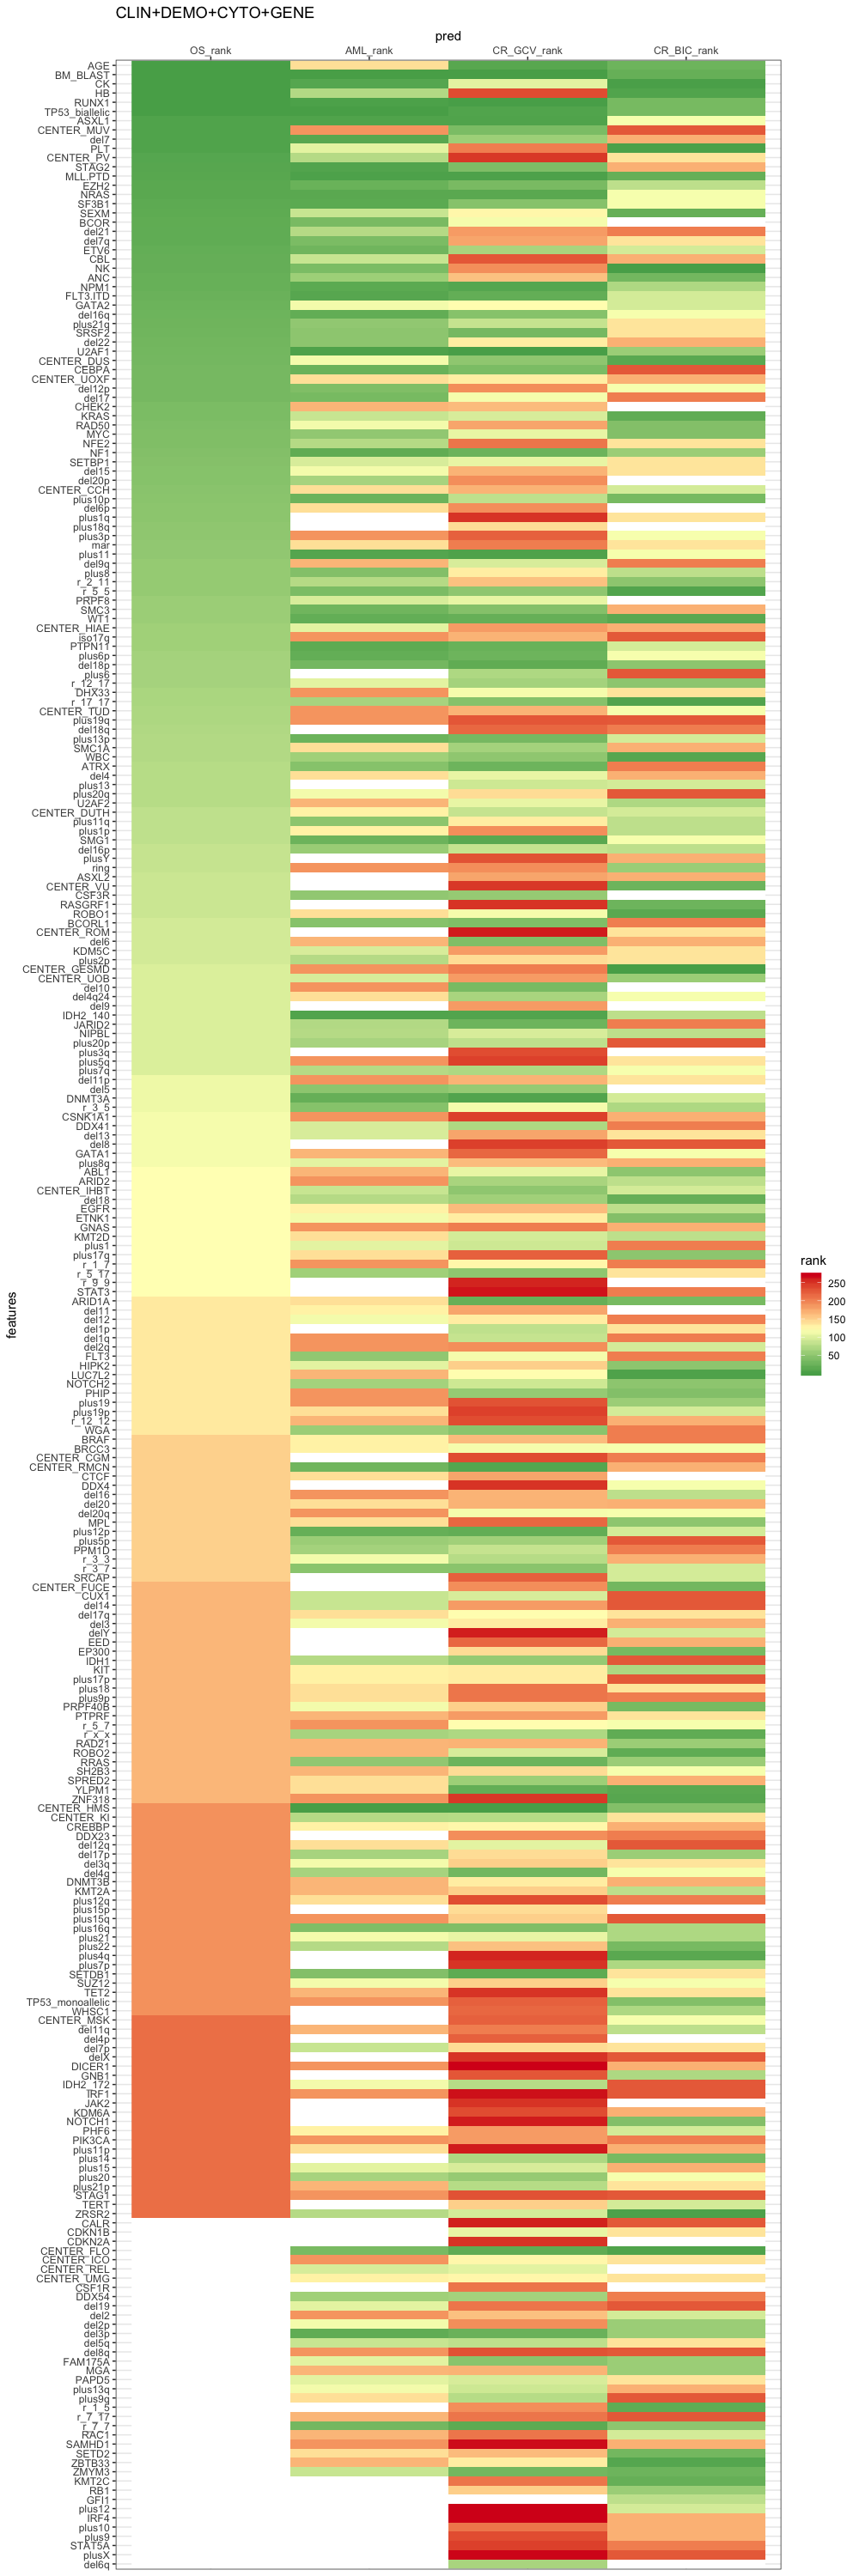

In [195]:
set_notebook_plot_size(10,30)
ggplot(CLIN_DEMO_CYTO_GENE_ranking, aes(features,pred)) +
  
  # geom raster heatmap
  geom_raster(aes(fill = rank), show.legend = TRUE) +
  scale_fill_gradient2(low="#1a9641", high="#d7191c",mid = "#ffffbf",midpoint=121,na.value = 'white') +
  scale_y_discrete(position = "right") +
  #theme(axis.text.x.top = element_text(angle = 30, hjust = 1)) +
  coord_flip() +
  ggtitle('CLIN+DEMO+CYTO+GENE')


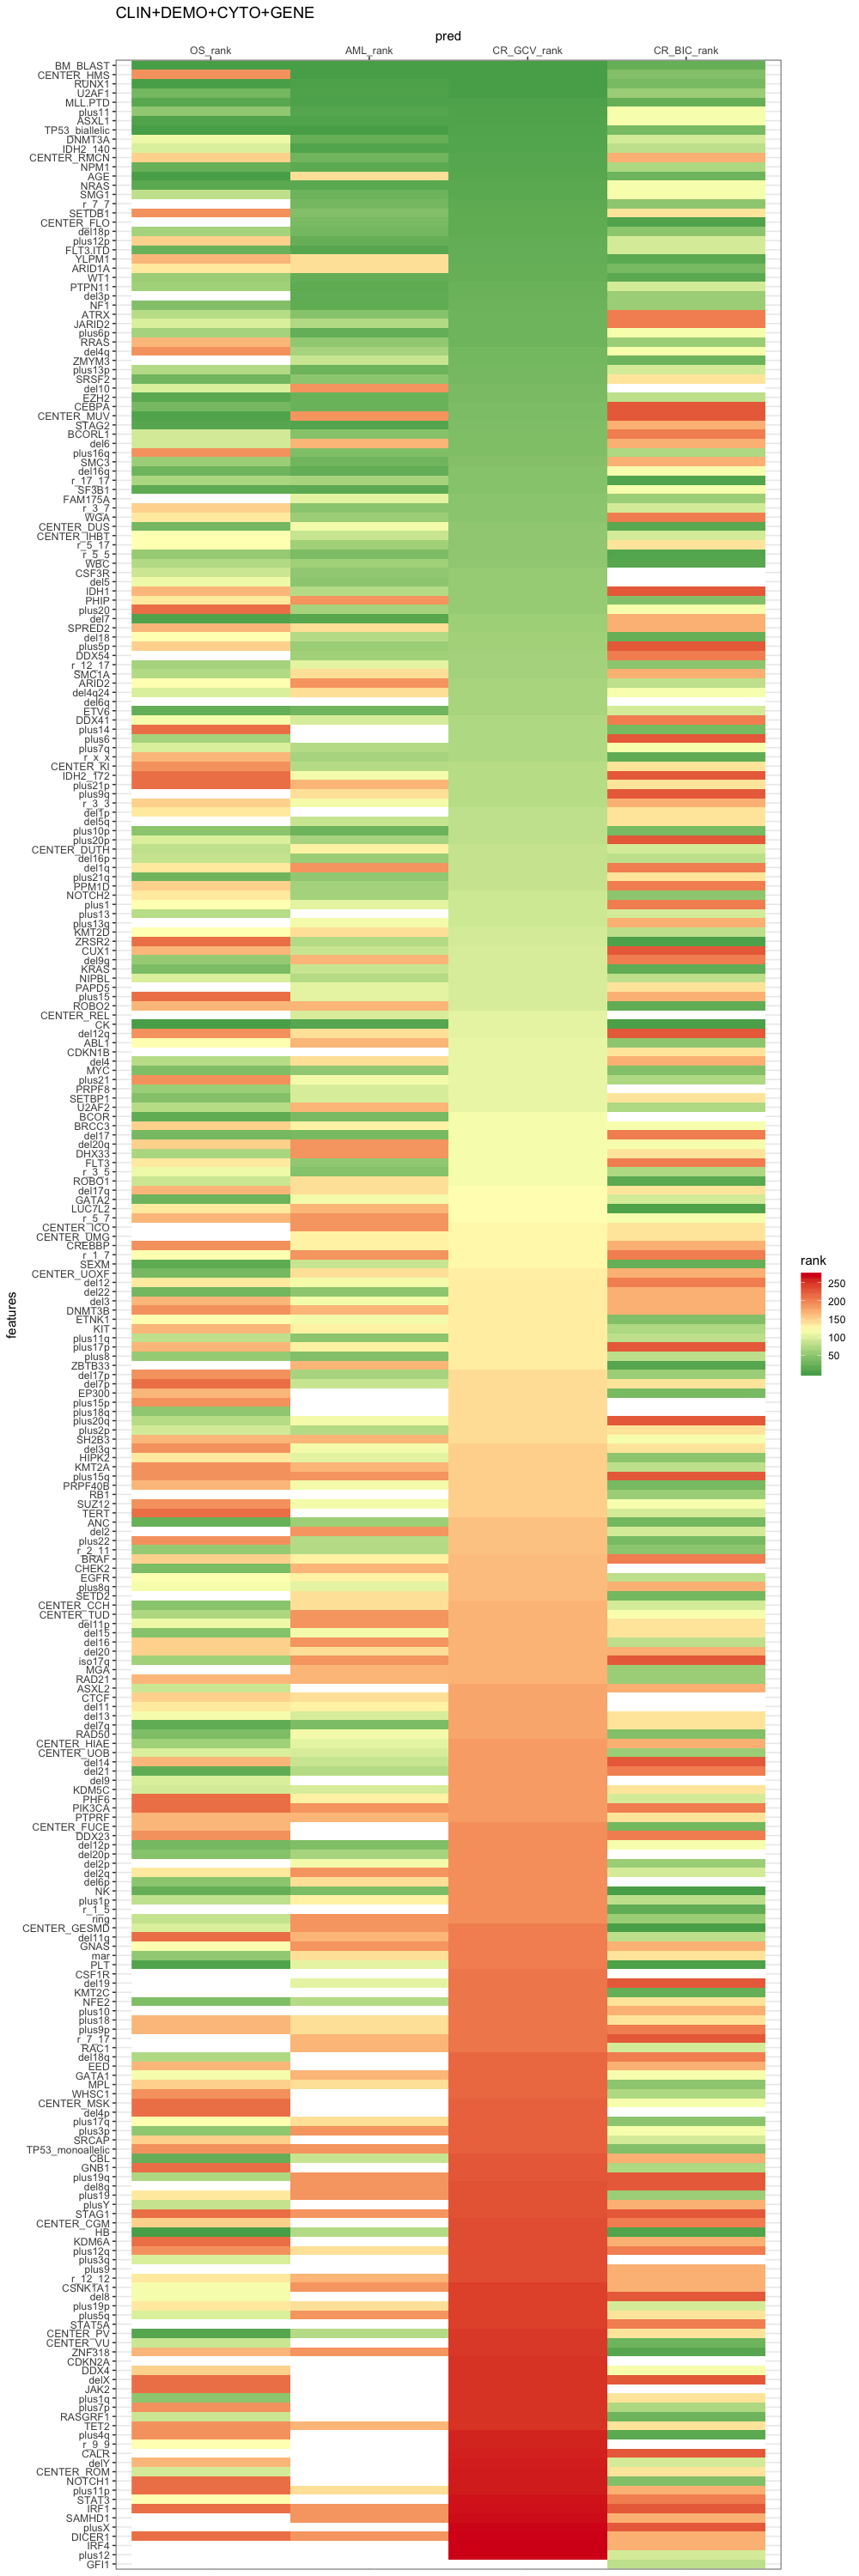

In [196]:
CLIN_DEMO_CYTO_GENE_ranking$features<-factor(CLIN_DEMO_CYTO_GENE_ranking$features,levels=rev(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$values))
set_notebook_plot_size(10,30)
ggplot(CLIN_DEMO_CYTO_GENE_ranking, aes(features,pred)) +
  
  # geom raster heatmap
  geom_raster(aes(fill = rank), show.legend = TRUE) +
  scale_fill_gradient2(low="#1a9641", high="#d7191c",mid = "#ffffbf",midpoint=121,na.value = 'white') +
  scale_y_discrete(position = "right") +
  #theme(axis.text.x.top = element_text(angle = 30, hjust = 1)) +
  coord_flip() +
  ggtitle('CLIN+DEMO+CYTO+GENE')


Competing risks using GCV to determine the best lambda select a mix of features from OS and AML transformation models, but mostly from the latter. There are still some differences as for competing risks, CK, NK and del7q are less important features and some other features are highly selected, such as YLPM1 and SPRED2, which are almost absent from the other models.

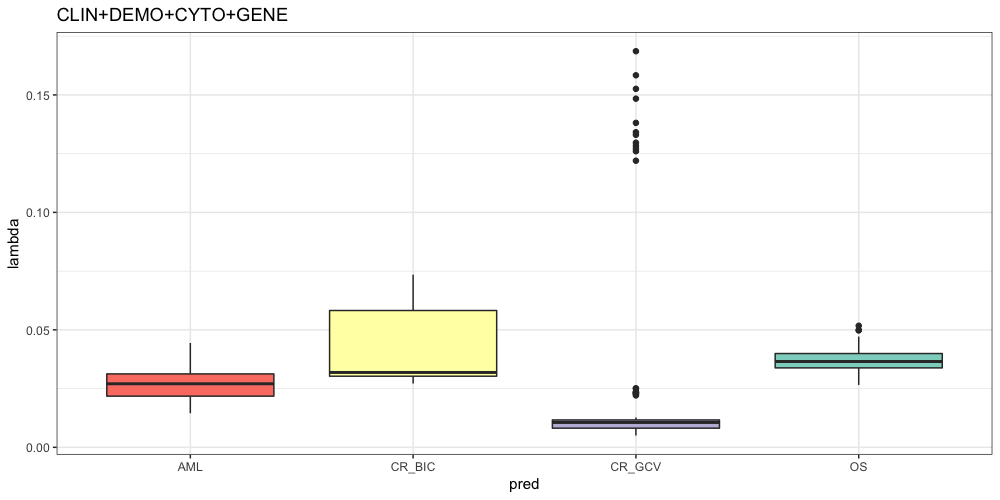

In [207]:
set_notebook_plot_size(10,5)
CLIN_DEMO_CYTO_GENE_OS_AML_CR_lambda<-rbind(read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_OS_AML_CR_lambda.tsv',sep='\t')[1:200,],
                                            read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_CR_lambda.tsv',sep='\t'),
                                            read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_CR_GCV_lambda.tsv',sep='\t'))
CLIN_DEMO_CYTO_GENE_OS_AML_CR_lambda$pred<-as.character(CLIN_DEMO_CYTO_GENE_OS_AML_CR_lambda$pred)
CLIN_DEMO_CYTO_GENE_OS_AML_CR_lambda$pred[201:300]<-'CR_BIC'

ggplot(CLIN_DEMO_CYTO_GENE_OS_AML_CR_lambda,aes(x=pred,y=lambda))+
  geom_boxplot(aes(fill=pred),notch = F) +
  scale_fill_manual(values = c('#fb8072','#ffffb3','#bebada','#8dd3c7'))+
  theme(legend.position = "none") +
  ggtitle('CLIN+DEMO+CYTO+GENE')


# Concordance index

The concordance index for competing risks is defined in Marcel Wolbers' paper *Concordance for prognostic models with competing risks* (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4059461/ ).
It is implemented in `pec` R package (https://github.com/cran/pec ).

In [122]:
# risk matrix
proba<-xtest%*%tmp # xtest defined before, tmp corresponding to the coef

In [123]:
cindex(proba,formula=Hist(time,status)~1,data.frame(ytest)) 

Cindex for competing risks



The c-index for right censored event times

Prediction models:

matrix 
matrix 

Right-censored response of a competing.risks model

No.Observations: 1196 

Pattern:
         
Cause     event right.censored
  1         216              0
  2         397              0
  unknown     0            583

Censoring model for IPCW: marginal model (Kaplan-Meier for censoring distribution) 

No data splitting: either apparent or independent test sample performance

Estimated C-index in % at time=18.5 

       AppCindex Pairs (Di=1,Ti<Tj) Concordant Pairs (Di=1,Dj=2) Concordant
matrix      70.6             161911     120488             30245      16646

### Behavior
To see if the concordance index is making sense and how it behaves for penalized competing risks, we compare 4 simple models: 
- IPSSR SCORE
- CLIN DEMO CYTO
- CLIN DEMO CYTO GENE
- CLIN DEMO CYTO GENE NMUT

Ten 5-fold CV are run for each model, so we get 50 concordance index tests that we can compare.

3 experiences failed for the same reason than above, we have then 47 tests left for each model.

In [127]:
IPSSR <- data.frame(read.table('../../data/updated_dataset/competing_risks/competing_risks_IPSSR_SCORE.tsv')[-c(4,24,44),]) #worked for IPSSR but not the other models
colnames(IPSSR) <- 'CI_test'
IPSSR$model<-'IPSSR_SCORE'
CLIN_DEMO_CYTO <- read.table('../../data/updated_dataset/competing_risks/competing_risks_CLIN_DEMO_CYTO.tsv')
colnames(CLIN_DEMO_CYTO) <- 'CI_test'
CLIN_DEMO_CYTO$model<-'CLIN_DEMO_CYTO'
CLIN_DEMO_CYTO_GENE <- read.table('../../data/updated_dataset/competing_risks/competing_risks_CLIN_DEMO_CYTO_GENE.tsv')
colnames(CLIN_DEMO_CYTO_GENE) <- 'CI_test'
CLIN_DEMO_CYTO_GENE$model<-'CLIN_DEMO_CYTO_GENE'
CLIN_DEMO_CYTO_GENE_NMUT <- read.table('../../data/updated_dataset/competing_risks/competing_risks_CLIN_DEMO_CYTO_GENE_NMUT.tsv')
colnames(CLIN_DEMO_CYTO_GENE_NMUT) <- 'CI_test'
CLIN_DEMO_CYTO_GENE_NMUT$model<-'CLIN_DEMO_CYTO_GENE_NMUT'


In [128]:
df_model <- rbind(
    IPSSR,
    CLIN_DEMO_CYTO,
    CLIN_DEMO_CYTO_GENE,
    CLIN_DEMO_CYTO_GENE_NMUT
)
df_model$model <- factor(df_model$model, levels=unique(df_model$model))
medians <- data.frame(models=levels(df_model$model))
medians$med <- signif(sapply(levels(df_model$model),function(x){return(median(df_model$CI_test[df_model$model==as.character(x)]))}),5)



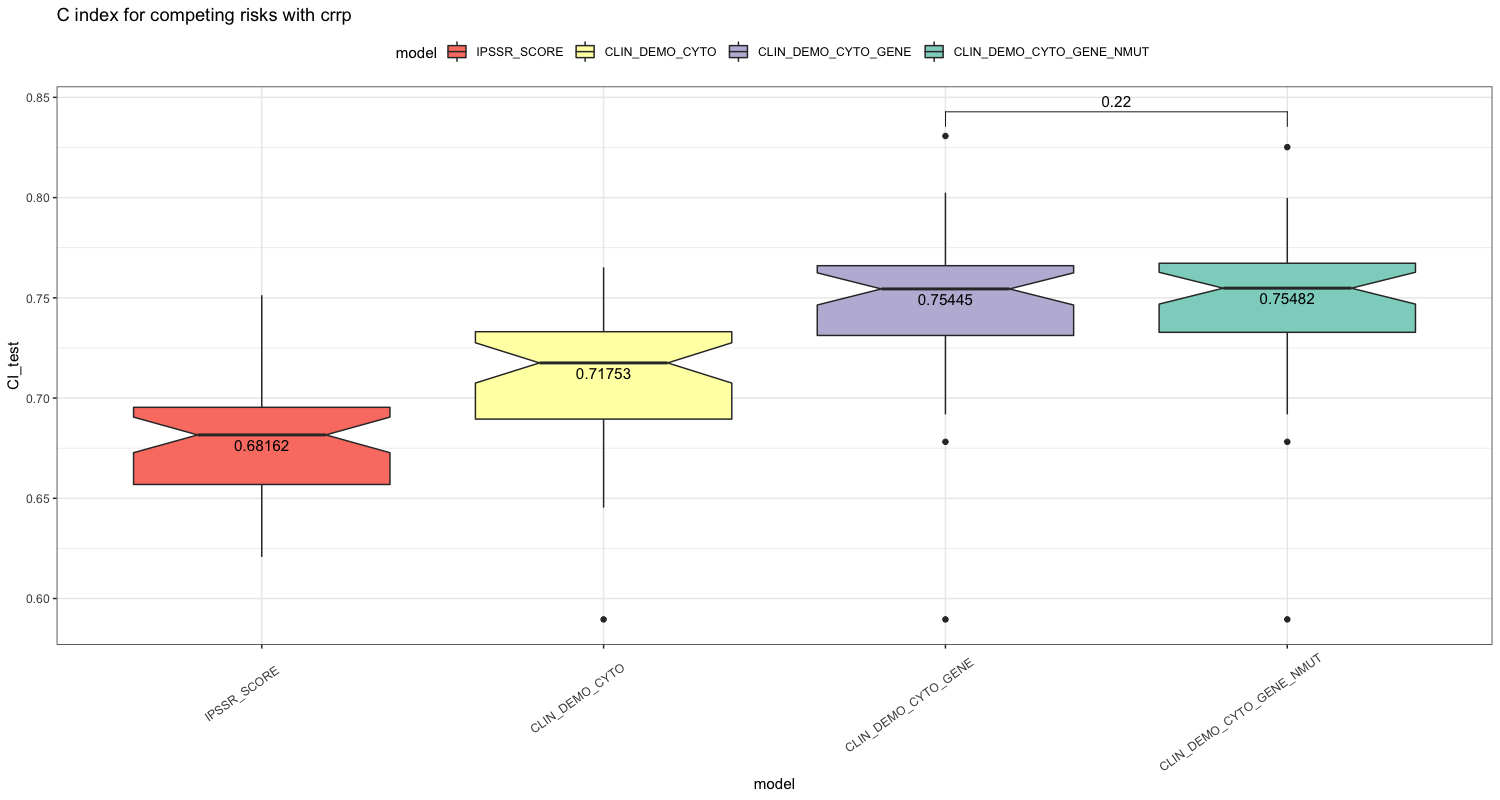

In [129]:
set_notebook_plot_size(15,8)

ggplot(df_model,aes(x=model,y=CI_test)) +
    geom_boxplot(aes(fill = model), notch=T)+
    scale_fill_manual(values = c('#fb8072','#ffffb3','#bebada','#8dd3c7'))+
    theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) +
    stat_compare_means(paired = T, comparisons = list(c(3,4)))+
    geom_text(aes(models, med-0.005, label=med,fill=NULL),data=medians )+
    ggtitle('C index for competing risks with crrp')
    

    

The behavior seems to be identical to the other concordance index for overall survival, and the values are not so different.

# Random forests

In [24]:
# CLIN_DEMO_CYTO_GENE
prep.CLIN_DEMO_CYTO_GENE = PrepareDesignMatrix(data=ddgo,
                                 use.nuisance=TRUE,
                                 response.name=c("time","fstatus"),
                                 feature.category.name = c("clin","wbc","age","clinicalother","cytoaberrations","mutations"),
                                 list.features=list.features)



In [28]:
cvfit_CLIN_DEMO_GENE_CYTO_rfs = rfsrc(Surv(time, status) ~ ., 
                                      data=data.frame(prep.CLIN_DEMO_CYTO_GENE$design,prep.CLIN_DEMO_CYTO_GENE$response),
                                      splitrule='logrankCR', 
                                      ntree=500,
                                      importance=TRUE)



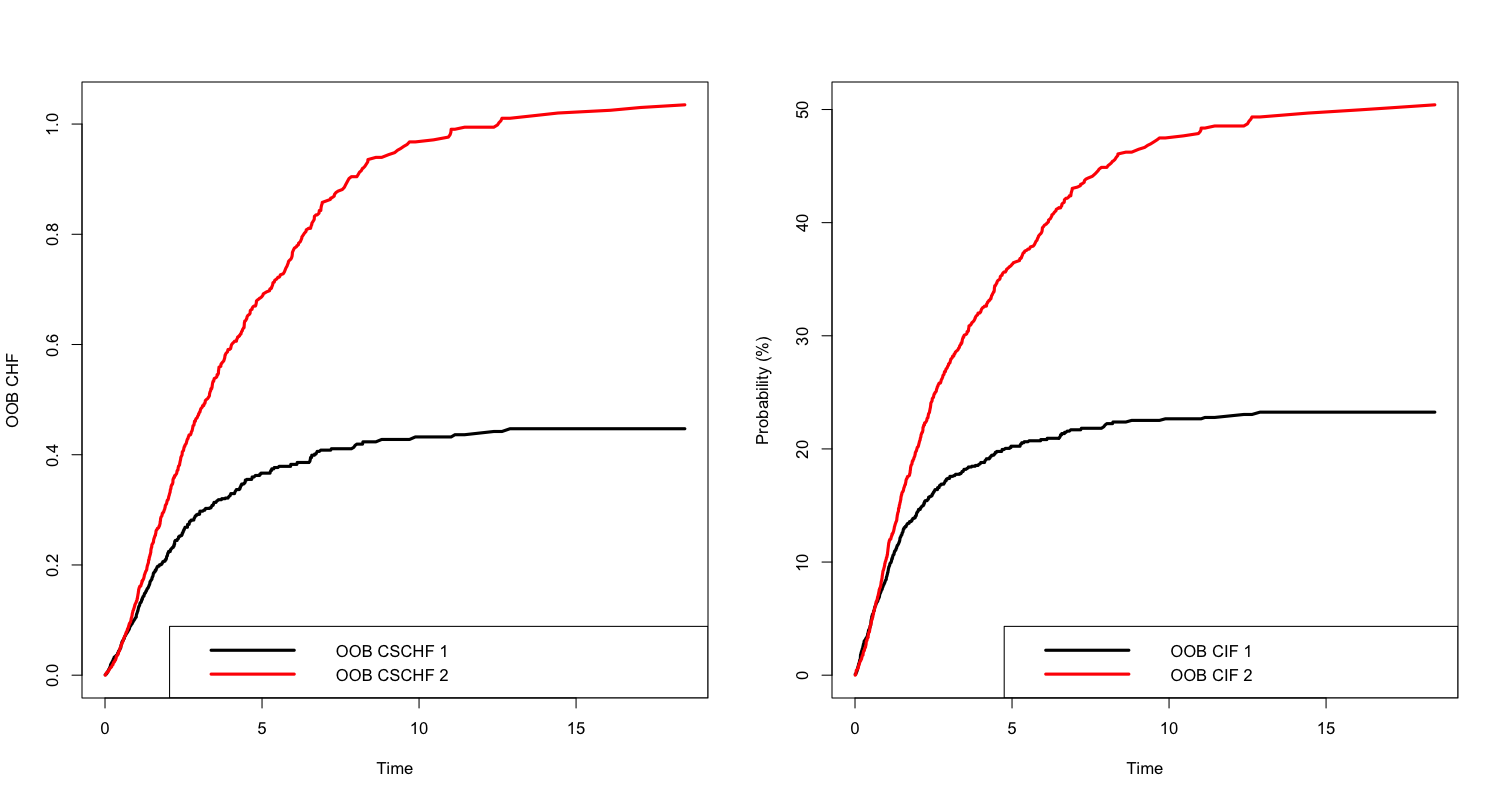

In [30]:
set_notebook_plot_size(15,8)
plot.competing.risk(cvfit_CLIN_DEMO_GENE_CYTO_rfs)

In [71]:
importance<-data.frame(cvfit_CLIN_DEMO_GENE_CYTO_rfs$importance)
importance<-rownames_to_column(.data = importance,var='features')


importance.1<-importance
importance.1<-importance.1[order(importance.1$event.1,decreasing=T),]
importance.1$rank<-1:nrow(importance.1)


importance.2<-importance
importance.2<-importance.2[order(importance.2$event.2,decreasing=T),]
importance.2$rank<-1:nrow(importance.2)

importance$rank.1 <- apply(importance,1,function(x){return(importance.1$rank[importance.1$features==x['features']])})
importance$rank.2 <- apply(importance,1,function(x){return(importance.2$rank[importance.2$features==x['features']])})


In [72]:
tail(importance)

features         event.1      event.2       rank.1 rank.2
267 ZMYM3            8.233702e-05 -3.240562e-05 61     194   
268 ZNF318           1.348203e-04 -1.177863e-04 47     244   
269 ZRSR2            2.001666e-04  4.140364e-04 44      40   
270 TP53_monoallelic 3.950461e-04  2.715906e-04 34      47   
271 TP53_biallelic   1.527646e-02 -2.432327e-04  2     263   
272 U2AF1            1.545849e-03  4.481908e-04 20      36

In [73]:
importance<-melt(importance[,c(1,4,5)],'features')
importance$features<-factor(importance$features,levels=rev(importance.1$features))
head(importance)

features    variable value
1 CENTER_CCH  rank.1    21  
2 CENTER_CGM  rank.1    87  
3 CENTER_DUS  rank.1    70  
4 CENTER_DUTH rank.1   238  
5 CENTER_FLO  rank.1   126  
6 CENTER_FUCE rank.1    88

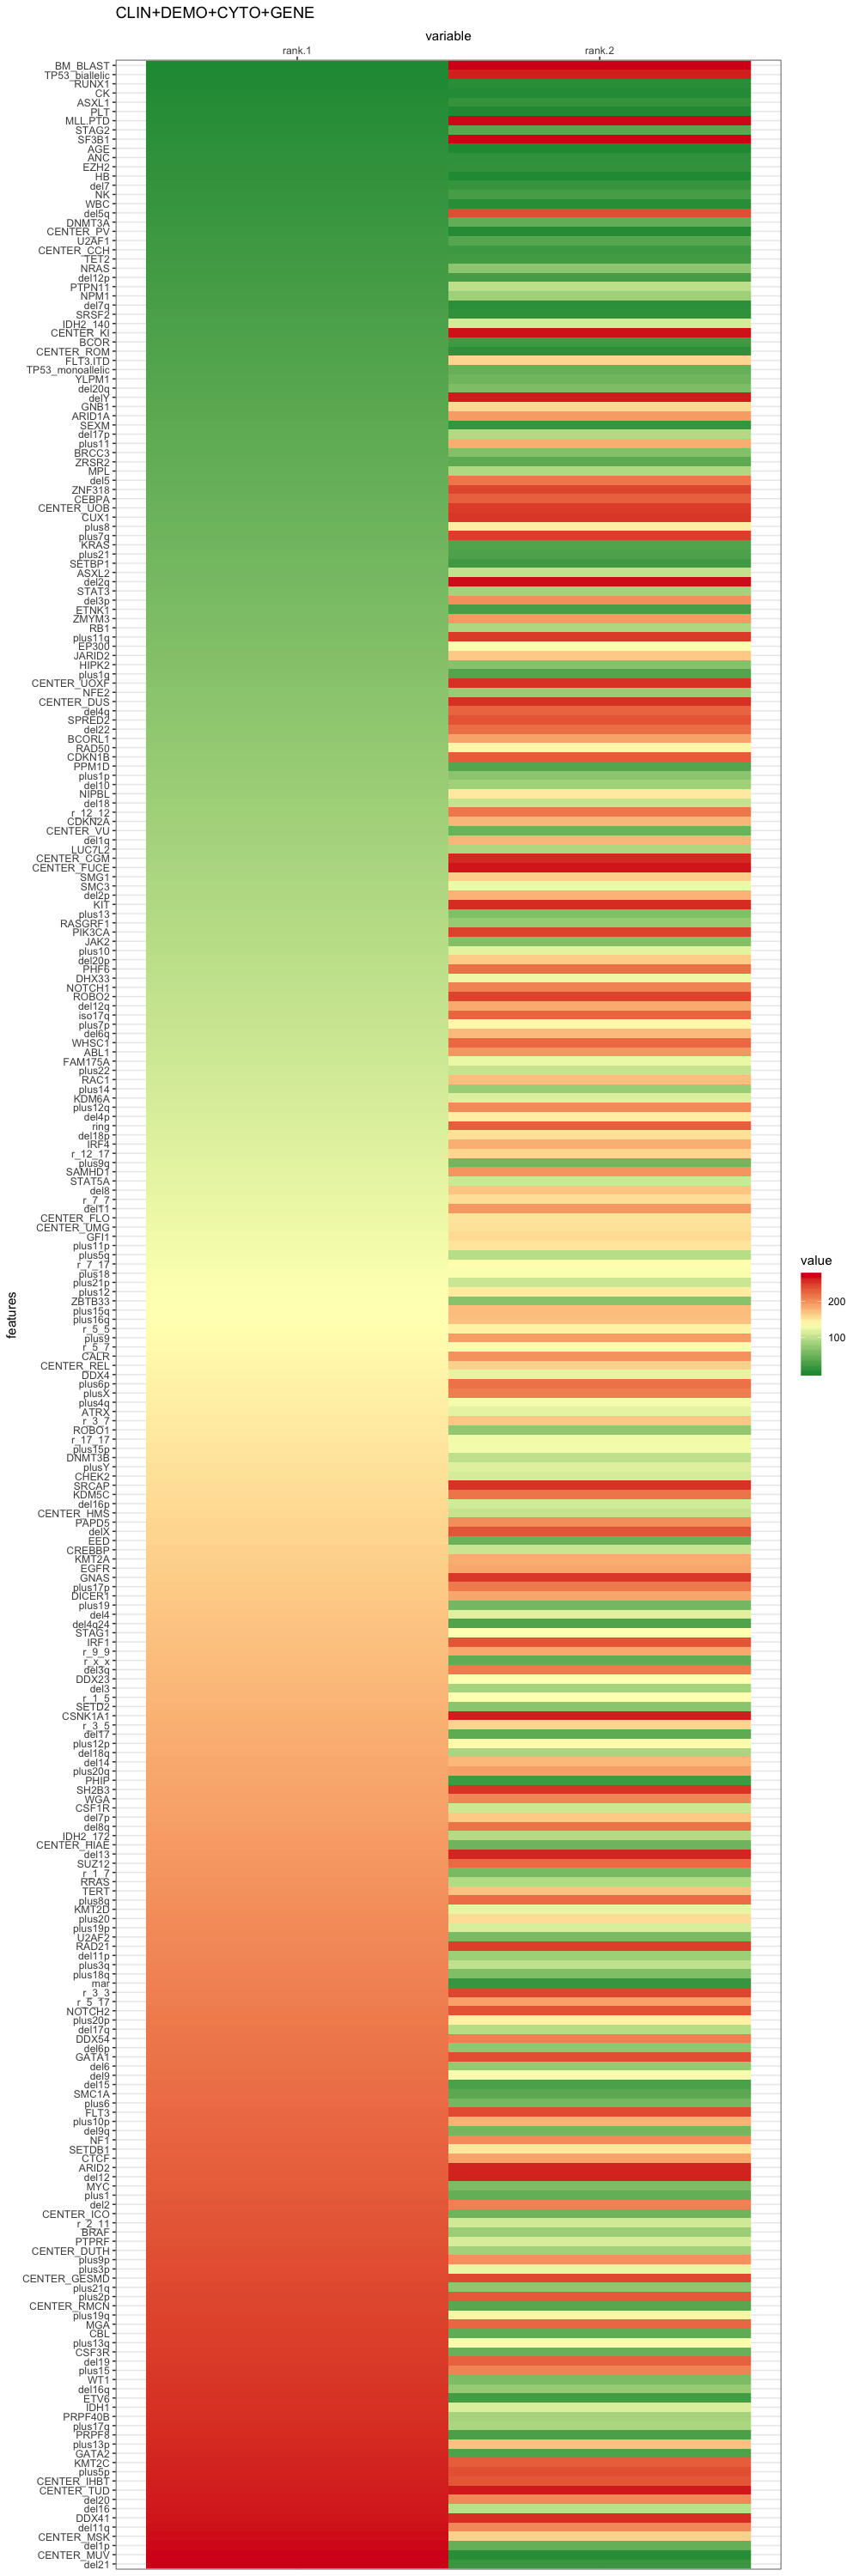

In [74]:
set_notebook_plot_size(10,30)
ggplot(importance, aes(features,variable)) +
  
  # geom raster heatmap
  geom_raster(aes(fill = value), show.legend = TRUE) +
  scale_fill_gradient2(low="#1a9641", high="#d7191c",mid = "#ffffbf",midpoint=136,na.value = 'white') +
  scale_y_discrete(position = "right") +
  #theme(axis.text.x.top = element_text(angle = 30, hjust = 1)) +
  coord_flip() +
  ggtitle('CLIN+DEMO+CYTO+GENE')

The second event is not making real sense biologically speaking, that is why strange features are selected while putting away important ones.

Let's compare the features with OS, AML and CR with GCV:

In [89]:
CLIN_DEMO_CYTO_GENE_CR_BIC <- read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_CR_long.tsv',header=T,sep='\t')
CLIN_DEMO_CYTO_GENE_CR_BIC$pred <- paste0(CLIN_DEMO_CYTO_GENE_CR_BIC$pred,'_BIC')

CLIN_DEMO_CYTO_GENE_CR_GCV <- read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_CR_GCV.tsv',header=T,sep='\t')
CLIN_DEMO_CYTO_GENE_CR_GCV$pred <- paste0(CLIN_DEMO_CYTO_GENE_CR_GCV$pred,'_GCV')

CLIN_DEMO_CYTO_GENE <- read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_OS_AML_CR.tsv',header=T,sep='\t')
CLIN_DEMO_CYTO_GENE_OS <- CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$pred=='OS',]
CLIN_DEMO_CYTO_GENE_AML <- CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$pred=='AML',]


In [91]:
CLIN_DEMO_CYTO_GENE_CR_GCV <- read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_CR_GCV.tsv',header=T,sep='\t')
CLIN_DEMO_CYTO_GENE_CR_GCV$pred <- paste0(CLIN_DEMO_CYTO_GENE_CR_GCV$pred,'_GCV')

CLIN_DEMO_CYTO_GENE <- read.table('../../data/updated_dataset/bootstrapping/CLIN_DEMO_CYTO_GENE_bootstrapping_OS_AML_CR.tsv',header=T,sep='\t')
CLIN_DEMO_CYTO_GENE_OS <- CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$pred=='OS',]
CLIN_DEMO_CYTO_GENE_AML <- CLIN_DEMO_CYTO_GENE[CLIN_DEMO_CYTO_GENE$pred=='AML',]


feature_count_CLIN_DEMO_CYTO_GENE_OS <- get_table(CLIN_DEMO_CYTO_GENE_OS[,'feature'],add_total_count = FALSE)[,1:2]
feature_count_CLIN_DEMO_CYTO_GENE_AML <- get_table(CLIN_DEMO_CYTO_GENE_AML[,'feature'],add_total_count = FALSE)[,1:2]
feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV <- get_table(CLIN_DEMO_CYTO_GENE_CR_GCV[,'feature'],add_total_count = FALSE)[,1:2]

# add missing features
all_features <- unique(importance.1$features)

features_missing_CR_GCV <- all_features[!all_features%in%feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$values]
features_missing_OS <- all_features[!all_features%in%feature_count_CLIN_DEMO_CYTO_GENE_OS$values]
features_missing_AML <- all_features[!all_features%in%feature_count_CLIN_DEMO_CYTO_GENE_AML$values]


feature_count_CLIN_DEMO_CYTO_GENE_OS <- rbind(feature_count_CLIN_DEMO_CYTO_GENE_OS,
                                        data.frame(values=features_missing_OS,
                                                   count=0))
feature_count_CLIN_DEMO_CYTO_GENE_AML <- rbind(feature_count_CLIN_DEMO_CYTO_GENE_AML,
                                        data.frame(values=features_missing_AML,
                                                   count=0))
feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV <- rbind(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV,
                                        data.frame(values=features_missing_CR_GCV,
                                                   count=0))



In [93]:



feature_count_CLIN_DEMO_CYTO_GENE_OS$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_OS)
feature_count_CLIN_DEMO_CYTO_GENE_AML$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_AML)
feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV)

CLIN_DEMO_CYTO_GENE_ranking <- data.frame(features=all_features,
                                     CR_RFS_rank=importance.1$rank)
CLIN_DEMO_CYTO_GENE_ranking$AML_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_AML$rank[feature_count_CLIN_DEMO_CYTO_GENE_AML$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$CR_GCV_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$rank[feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$OS_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_OS$rank[feature_count_CLIN_DEMO_CYTO_GENE_OS$values==x])})



In [94]:
spearman_cor <- data.frame(cbind(cor(CLIN_DEMO_CYTO_GENE_ranking$OS_rank, CLIN_DEMO_CYTO_GENE_ranking$AML_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$OS_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_GCV_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$OS_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_RFS_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$AML_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_GCV_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$AML_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_RFS_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$CR_GCV_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_RFS_rank, method=c("spearman"))))
colnames(spearman_cor)<-c('OS_AML','OS_CR_GCV','OS_CR_RFS','AML_CR_GCV','AML_CR_RFS','CR_GCV_CR_RFS')
rownames(spearman_cor)<-"Spearman_correlation"
spearman_cor

OS_AML    OS_CR_GCV OS_CR_RFS AML_CR_GCV AML_CR_RFS
Spearman_correlation 0.4478183 0.2866358 0.17281   0.6894127  0.1749167 
                     CR_GCV_CR_RFS
Spearman_correlation 0.09699433

In [95]:
feature_count_CLIN_DEMO_CYTO_GENE_OS$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_OS, with_NA = T)
feature_count_CLIN_DEMO_CYTO_GENE_AML$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_AML, with_NA = T)
feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$rank <- ranking(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV, with_NA = T)


CLIN_DEMO_CYTO_GENE_ranking <- data.frame(features=all_features,
                                     CR_RFS_rank=importance.1$rank)
CLIN_DEMO_CYTO_GENE_ranking$AML_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_AML$rank[feature_count_CLIN_DEMO_CYTO_GENE_AML$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$CR_GCV_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$rank[feature_count_CLIN_DEMO_CYTO_GENE_CR_GCV$values==x])})
CLIN_DEMO_CYTO_GENE_ranking$OS_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(feature_count_CLIN_DEMO_CYTO_GENE_OS$rank[feature_count_CLIN_DEMO_CYTO_GENE_OS$values==x])})


CLIN_DEMO_CYTO_GENE_ranking<-melt(CLIN_DEMO_CYTO_GENE_ranking,id='features')
colnames(CLIN_DEMO_CYTO_GENE_ranking)<-c('features','pred','rank')
CLIN_DEMO_CYTO_GENE_ranking$features<-factor(CLIN_DEMO_CYTO_GENE_ranking$features,levels=rev(importance.1$features))

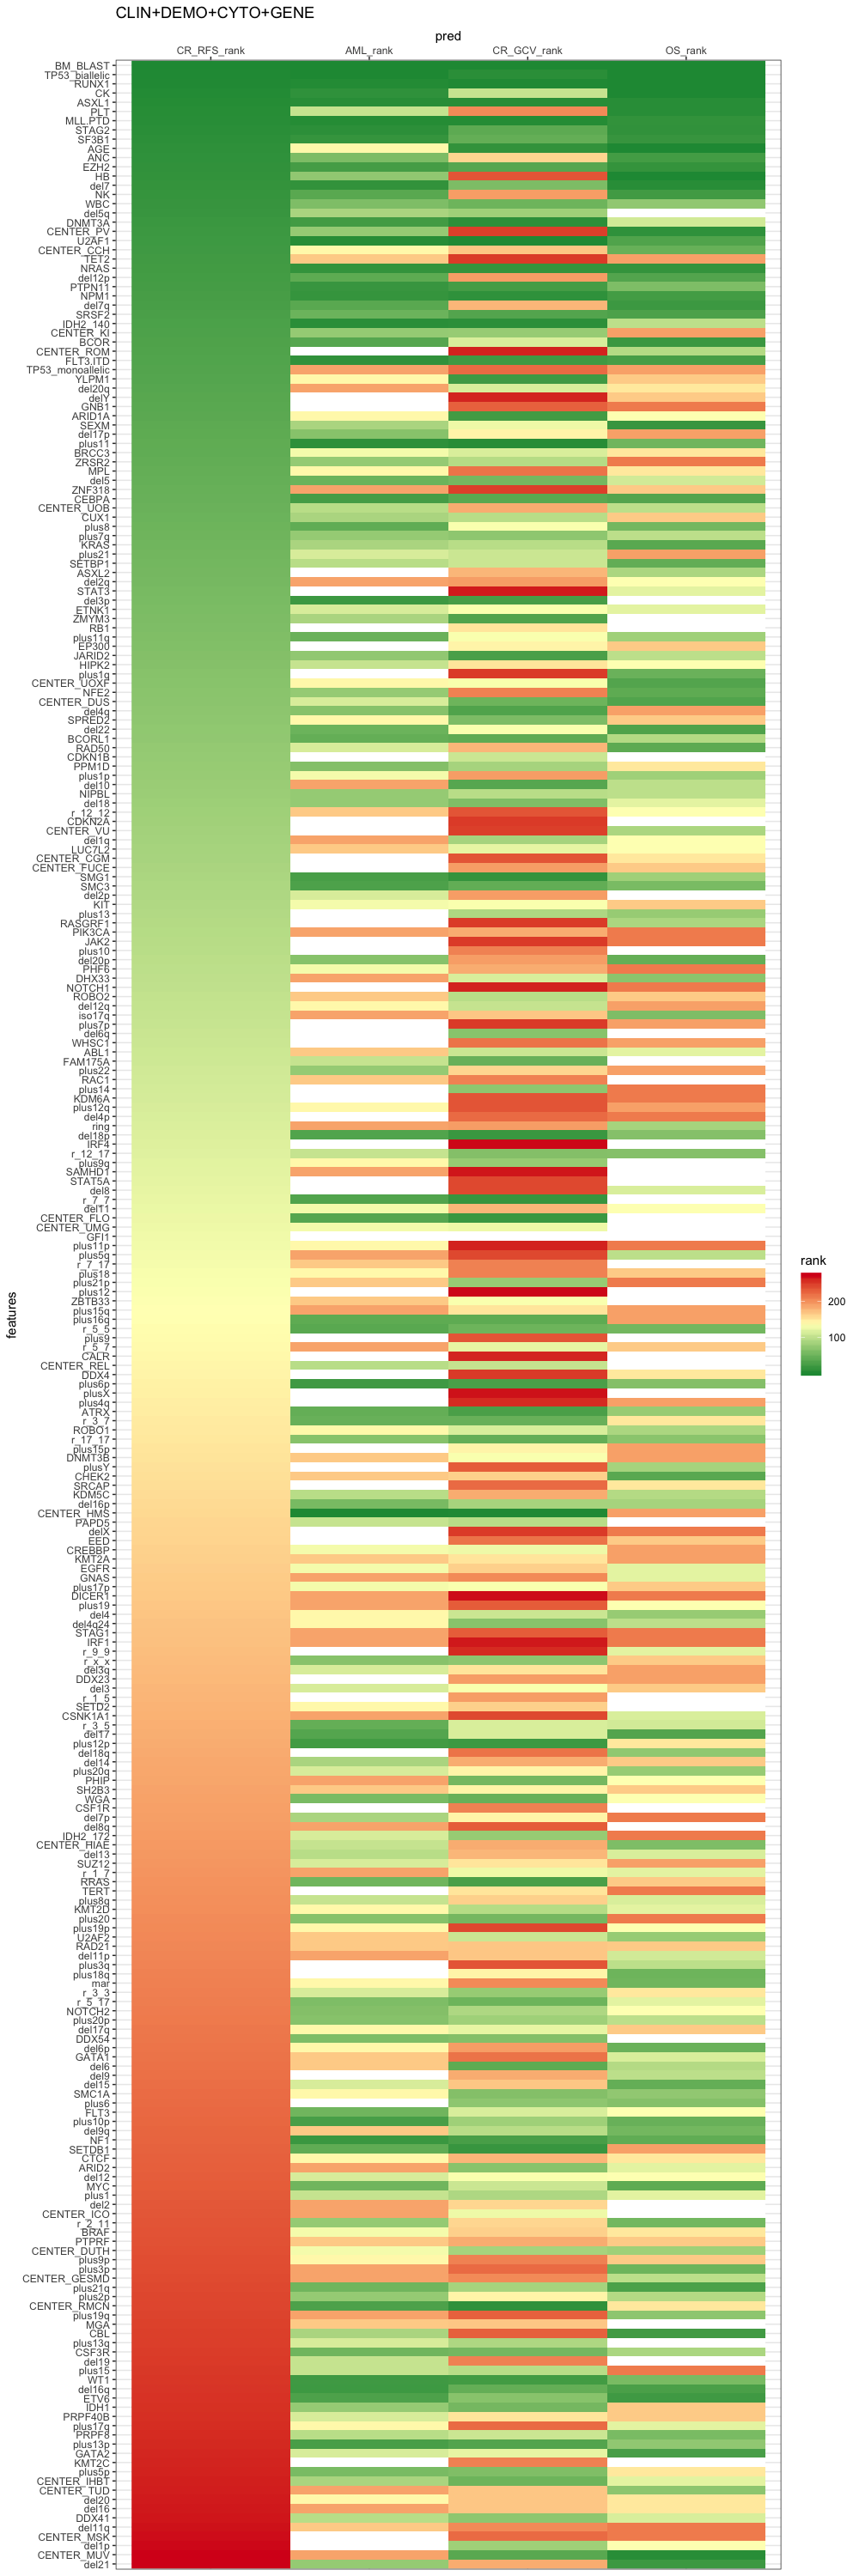

In [96]:
set_notebook_plot_size(10,30)
ggplot(CLIN_DEMO_CYTO_GENE_ranking, aes(features,pred)) +
  
  # geom raster heatmap
  geom_raster(aes(fill = rank), show.legend = TRUE) +
  scale_fill_gradient2(low="#1a9641", high="#d7191c",mid = "#ffffbf",midpoint=136,na.value = 'white') +
  scale_y_discrete(position = "right") +
  #theme(axis.text.x.top = element_text(angle = 30, hjust = 1)) +
  coord_flip() +
  ggtitle('CLIN+DEMO+CYTO+GENE')


The feature space of random forests for competing risks are pretty unique and is very different from the one from `crrp` package, even though the top features are similar. But the algorithms used are different, so let's compare the endpoints with the same algorithm: random forests.

#### OS

In [97]:
# CLIN_DEMO_CYTO_GENE
prep.CLIN_DEMO_CYTO_GENE = PrepareDesignMatrix(data=ddgo,
                                 use.nuisance=TRUE,
                                 response.name=c("os_diag_years","os_status"),
                                 feature.category.name = c("clin","wbc","age","clinicalother","cytoaberrations","mutations"),
                                 list.features=list.features)



In [100]:
cvfit_CLIN_DEMO_GENE_CYTO_rfs_OS = rfsrc(Surv(time, status) ~ ., 
                                      data=data.frame(prep.CLIN_DEMO_CYTO_GENE$design,prep.CLIN_DEMO_CYTO_GENE$response), 
                                      ntree=500,
                                      importance=TRUE)



In [106]:
importance_OS <- data.frame(cvfit_CLIN_DEMO_GENE_CYTO_rfs_OS$importance)
importance_OS <- rownames_to_column(importance_OS,'features')
importance_OS<-importance_OS[order(importance_OS[,2],decreasing=T),]
importance_OS$rank<-1:nrow(importance_OS)

#### AML transformation

In [107]:
# CLIN_DEMO_CYTO_GENE
prep.CLIN_DEMO_CYTO_GENE = PrepareDesignMatrix(data=ddgo,
                                 use.nuisance=TRUE,
                                 response.name=c("aml_diag_years","aml_status"),
                                 feature.category.name = c("clin","wbc","age","clinicalother","cytoaberrations","mutations"),
                                 list.features=list.features)



In [108]:
cvfit_CLIN_DEMO_GENE_CYTO_rfs_AML = rfsrc(Surv(time, status) ~ ., 
                                      data=data.frame(prep.CLIN_DEMO_CYTO_GENE$design,prep.CLIN_DEMO_CYTO_GENE$response), 
                                      ntree=500,
                                      importance=TRUE)



In [109]:
importance_AML <- data.frame(cvfit_CLIN_DEMO_GENE_CYTO_rfs_AML$importance)
importance_AML <- rownames_to_column(importance_AML,'features')
importance_AML<-importance_AML[order(importance_AML[,2],decreasing=T),]
importance_AML$rank<-1:nrow(importance_AML)

#### Comparison

In [114]:
CLIN_DEMO_CYTO_GENE_ranking <- data.frame(features=importance.1$features,
                                     CR_rank=importance.1$rank)
CLIN_DEMO_CYTO_GENE_ranking$AML_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(importance_AML$rank[importance_AML$features==x])})
CLIN_DEMO_CYTO_GENE_ranking$OS_rank<-sapply(CLIN_DEMO_CYTO_GENE_ranking$features,function(x){
    return(importance_OS$rank[importance_OS$features==x])})




In [116]:
spearman_cor <- data.frame(cbind(cor(CLIN_DEMO_CYTO_GENE_ranking$OS_rank, CLIN_DEMO_CYTO_GENE_ranking$AML_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$OS_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_rank, method=c("spearman")),
                             cor(CLIN_DEMO_CYTO_GENE_ranking$AML_rank, CLIN_DEMO_CYTO_GENE_ranking$CR_rank, method=c("spearman"))))
colnames(spearman_cor)<-c('OS_AML','OS_CR','AML_CR')
rownames(spearman_cor)<-"Spearman_correlation"
spearman_cor

OS_AML   OS_CR    AML_CR   
Spearman_correlation 0.516985 0.247431 0.2080398

In [117]:
CLIN_DEMO_CYTO_GENE_ranking<-melt(CLIN_DEMO_CYTO_GENE_ranking,id='features')
colnames(CLIN_DEMO_CYTO_GENE_ranking)<-c('features','pred','rank')
CLIN_DEMO_CYTO_GENE_ranking$features<-factor(CLIN_DEMO_CYTO_GENE_ranking$features,levels=rev(importance.1$features))

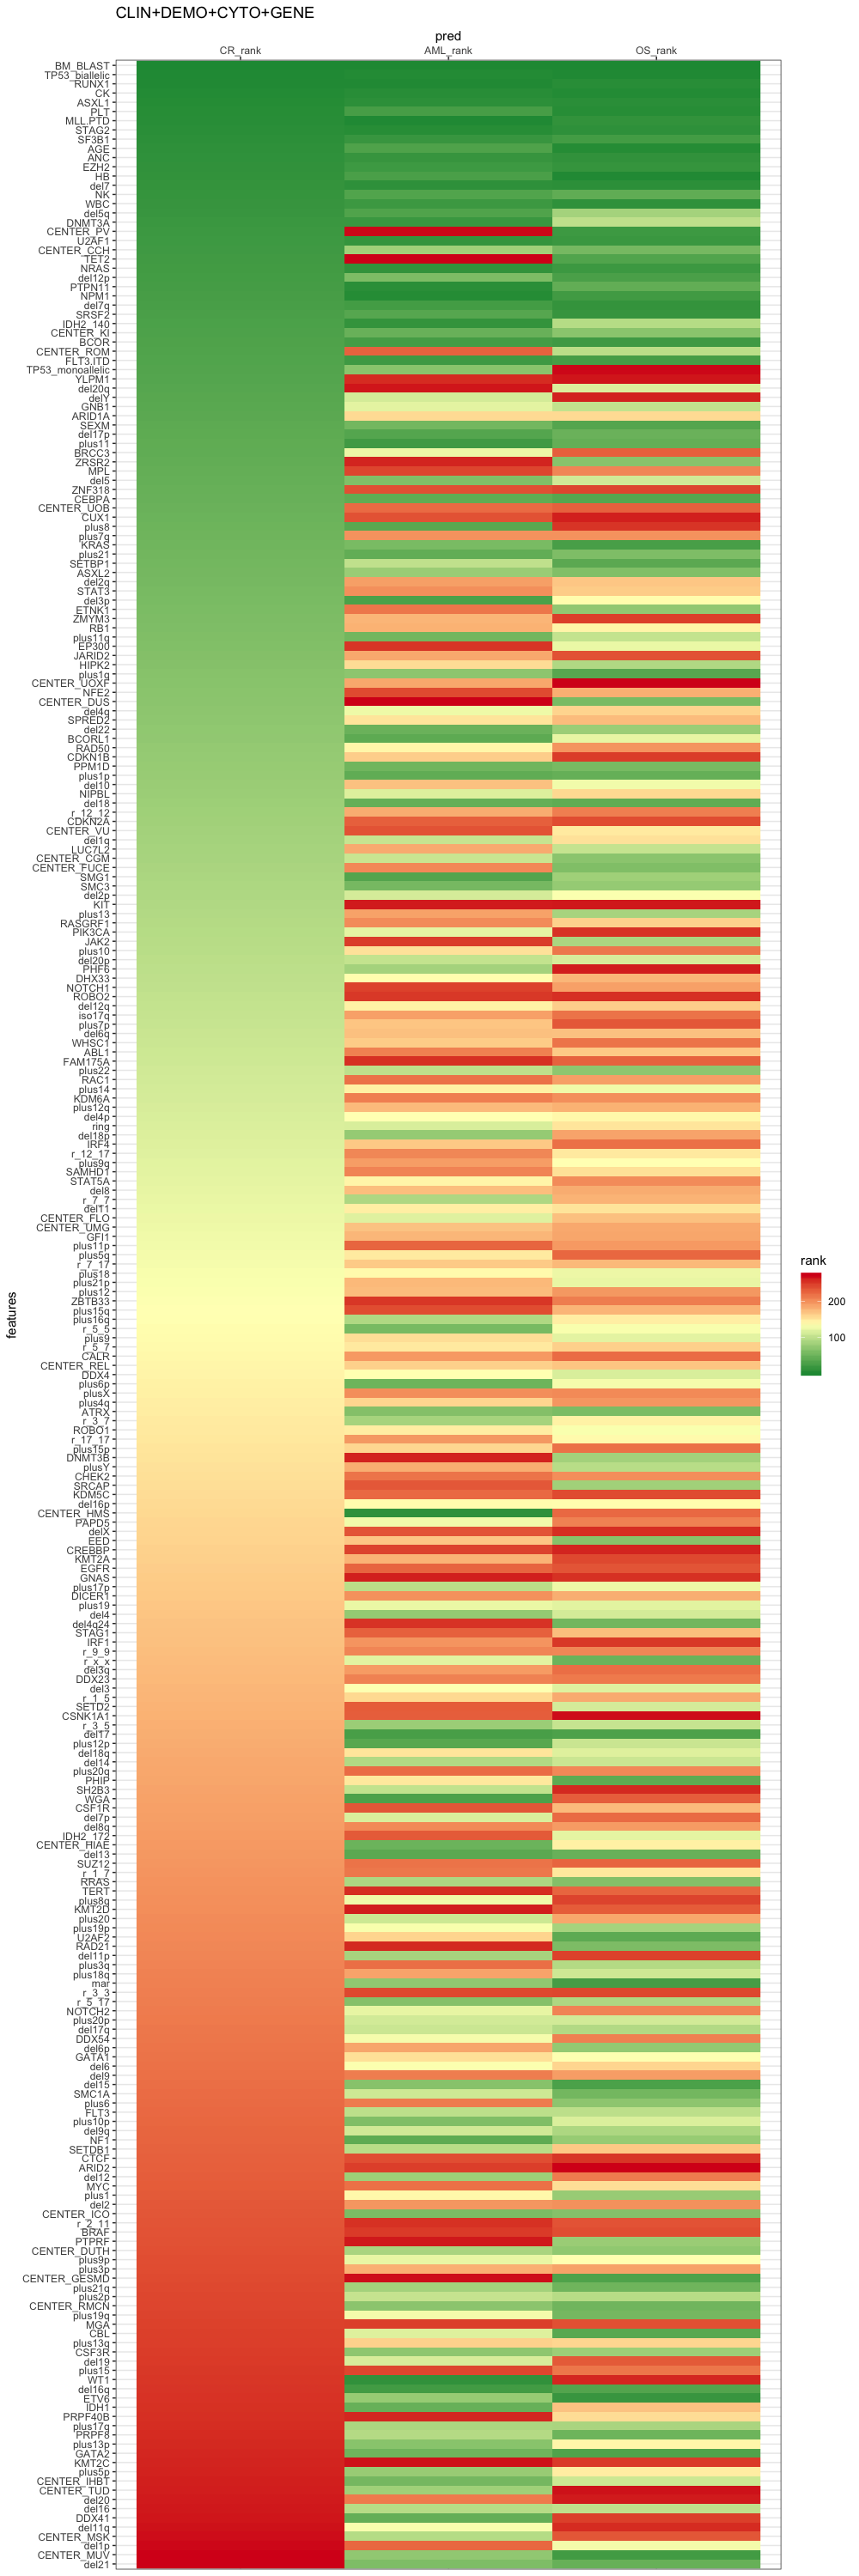

In [118]:
set_notebook_plot_size(10,30)
ggplot(CLIN_DEMO_CYTO_GENE_ranking, aes(features,pred)) +
  
  # geom raster heatmap
  geom_raster(aes(fill = rank), show.legend = TRUE) +
  scale_fill_gradient2(low="#1a9641", high="#d7191c",mid = "#ffffbf",midpoint=136,na.value = 'white') +
  scale_y_discrete(position = "right") +
  #theme(axis.text.x.top = element_text(angle = 30, hjust = 1)) +
  coord_flip() +
  ggtitle('CLIN+DEMO+CYTO+GENE')


We get more similar results but competing risks is more unique, and we still have similar top features.

Let's look at the concordance index for competing risks with random random forests for some models:

In [123]:
IPSSR <- read.table('../../data/updated_dataset/competing_risks/competing_risks_IPSSR_SCORE_RFS.tsv')
colnames(IPSSR) <- 'CI_test'
IPSSR$model<-'IPSSR_SCORE'
CLIN_DEMO_CYTO <- read.table('../../data/updated_dataset/competing_risks/competing_risks_CLIN_DEMO_CYTO_RFS.tsv')
colnames(CLIN_DEMO_CYTO) <- 'CI_test'
CLIN_DEMO_CYTO$model<-'CLIN_DEMO_CYTO'
CLIN_DEMO_CYTO_GENE <- read.table('../../data/updated_dataset/competing_risks/competing_risks_CLIN_DEMO_CYTO_GENE_RFS.tsv')
colnames(CLIN_DEMO_CYTO_GENE) <- 'CI_test'
CLIN_DEMO_CYTO_GENE$model<-'CLIN_DEMO_CYTO_GENE'
CLIN_DEMO_CYTO_GENE_NMUT <- read.table('../../data/updated_dataset/competing_risks/competing_risks_CLIN_DEMO_CYTO_GENE_NMUT_RFS.tsv')
colnames(CLIN_DEMO_CYTO_GENE_NMUT) <- 'CI_test'
CLIN_DEMO_CYTO_GENE_NMUT$model<-'CLIN_DEMO_CYTO_GENE_NMUT'


In [124]:
df_model <- rbind(
    IPSSR,
    CLIN_DEMO_CYTO,
    CLIN_DEMO_CYTO_GENE,
    CLIN_DEMO_CYTO_GENE_NMUT
)
df_model$model <- factor(df_model$model, levels=unique(df_model$model))
medians <- data.frame(models=levels(df_model$model))
medians$med <- signif(sapply(levels(df_model$model),function(x){return(median(df_model$CI_test[df_model$model==as.character(x)]))}),5)



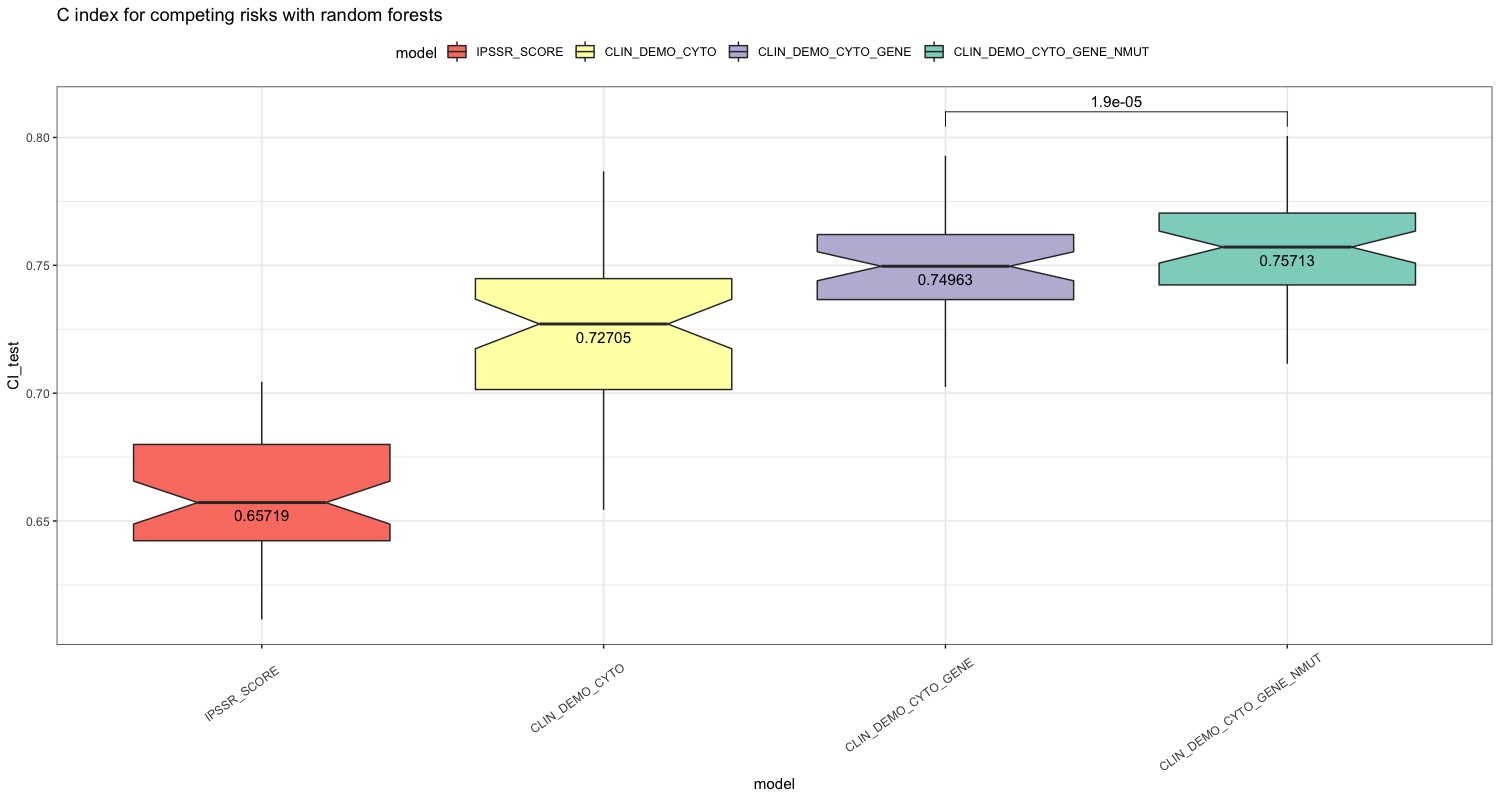

In [126]:
set_notebook_plot_size(15,8)

ggplot(df_model,aes(x=model,y=CI_test)) +
    geom_boxplot(aes(fill = model), notch=T)+
    scale_fill_manual(values = c('#fb8072','#ffffb3','#bebada','#8dd3c7'))+
    theme(legend.position="top",axis.text.x = element_text(angle = 35, hjust = 0.8,vjust=0.8)) +
    stat_compare_means(paired = T, comparisons = list(c(3,4)))+
    geom_text(aes(models, med-0.005, label=med,fill=NULL),data=medians )+
    ggtitle('C index for competing risks with random forests')
    

    

This is how the concordance index behaves for competing risks with random forests, so very similar than the results obtained using `crrp` package, with almost identical medians for each model. Surprisingly `nmut` here is increasing the C index significantly, which was not the case with `crrp`.